# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

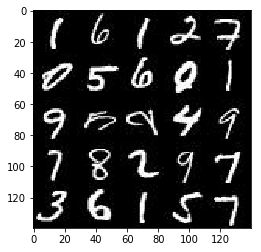

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

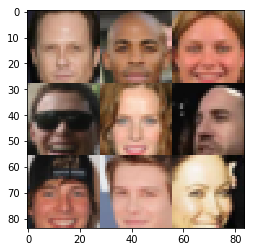

In [3]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_holders = tf.placeholder(dtype=tf.float32, shape=[None, image_width, image_height, image_channels])
    z_holders = tf.placeholder(dtype=tf.float32, shape=[None, z_dim])
    lr = tf.placeholder(tf.float32)
    return real_holders, z_holders, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    kernel_init = tf.contrib.layers.xavier_initializer()
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, kernel_initializer=kernel_init,padding='same')
        lrelu1 = tf.maximum(x1, alpha*x1) # output shape here is 14x14x64
        
        x2 = tf.layers.conv2d(lrelu1, 128, 3, strides=2, kernel_initializer=kernel_init,padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        lrelu2 = tf.maximum(bn2, alpha*bn2)#7x7x128
        
        x3 = tf.layers.conv2d(lrelu2, 256, 3, strides=2, kernel_initializer=kernel_init,padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        lrelu3 = tf.maximum(x3, alpha*x3)#4x4x256
        
        flatten = tf.reshape(lrelu3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    kernel_init = tf.contrib.layers.xavier_initializer()
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        lrelu1 = tf.maximum(x1, alpha*x1)#7x7x512
        #print(lrelu1.get_shape())
        x2 = tf.layers.conv2d_transpose(lrelu1, 256, 5,kernel_initializer=kernel_init ,strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = tf.maximum(alpha * x2, x2)#14x14x256
        #print(lrelu2.get_shape())
        x3 = tf.layers.conv2d_transpose(lrelu2, 128, 5,kernel_initializer=kernel_init ,strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = tf.maximum(alpha*x3, x3)#28x28x128
        
        final = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, 3, kernel_initializer=kernel_init,strides=1, padding='same')
        output = tf.tanh(final)
    
    return output

# x1 = tf.layers.dense(z, 4*4*512)

# x1 = tf.reshape(x1, (-1, 4, 4, 512))
# bn1 = tf.layers.batch_normalization(x1, training=is_train)
# lrelu1 = tf.maximum(x1, alpha*x1)#4x4x512

# x2 = tf.layers.conv2d_transpose(lrelu1, 256, 8, strides=2, padding='valid')
# bn2 = tf.layers.batch_normalization(x2, training=is_train)
# lrelu2 = tf.maximum(alpha * x2, x2)#14x14x256

# x3 = tf.layers.conv2d_transpose(lrelu2, 128, 5, strides=2, padding='same')
# bn3 = tf.layers.batch_normalization(x3, training=is_train)
# lrelu3 = tf.maximum(alpha*x3, x3)#28x28x128

# final = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, 3, strides=1, padding='same')
# output = tf.tanh(final)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    g_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    d_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    samples, losses = [], []
    n_batch = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                n_batch += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})                
                
                if n_batch%10 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{} ".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}  ".format(train_loss_d),
                          "Generator Loss: {:.4f}  ".format(train_loss_g))
                    losses.append([train_loss_d, train_loss_g])
                
                if n_batch%100 == 0:
                    gen_samples = sess.run(
                                           generator(input_z, data_shape[3], is_train=False), 
                                           feed_dict={input_z:batch_z})
                    samples.append(gen_samples)
                    
                    show_generator_output(sess, 
                                          n_images=len(batch_images), 
                                          input_z= input_z, 
                                          out_channel_dim=data_shape[3],
                                          image_mode = data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2  Discriminator Loss: 1.1159   Generator Loss: 0.6186  
Epoch 0/2  Discriminator Loss: 1.1288   Generator Loss: 0.6224  
Epoch 0/2  Discriminator Loss: 1.0312   Generator Loss: 0.7088  
Epoch 0/2  Discriminator Loss: 0.8472   Generator Loss: 0.9195  
Epoch 0/2  Discriminator Loss: 0.5668   Generator Loss: 1.5657  
Epoch 0/2  Discriminator Loss: 0.4151   Generator Loss: 2.5655  
Epoch 0/2  Discriminator Loss: 0.7477   Generator Loss: 1.2564  
Epoch 0/2  Discriminator Loss: 1.1023   Generator Loss: 1.2917  
Epoch 0/2  Discriminator Loss: 1.0073   Generator Loss: 1.0433  
Epoch 0/2  Discriminator Loss: 1.1005   Generator Loss: 0.9599  


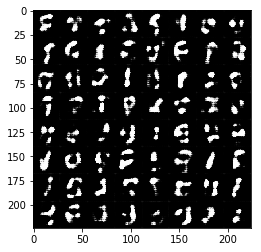

Epoch 0/2  Discriminator Loss: 1.0738   Generator Loss: 1.2249  
Epoch 0/2  Discriminator Loss: 1.0137   Generator Loss: 1.1548  
Epoch 0/2  Discriminator Loss: 1.0854   Generator Loss: 1.0610  
Epoch 0/2  Discriminator Loss: 1.0085   Generator Loss: 1.1512  
Epoch 0/2  Discriminator Loss: 1.1013   Generator Loss: 0.8334  
Epoch 0/2  Discriminator Loss: 1.1857   Generator Loss: 0.9475  
Epoch 0/2  Discriminator Loss: 0.9536   Generator Loss: 1.3981  
Epoch 0/2  Discriminator Loss: 1.0103   Generator Loss: 1.3130  
Epoch 0/2  Discriminator Loss: 1.0925   Generator Loss: 1.1833  
Epoch 0/2  Discriminator Loss: 1.3043   Generator Loss: 1.0228  


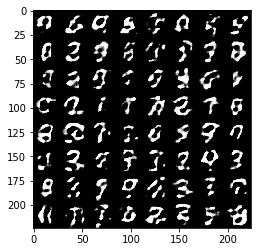

Epoch 0/2  Discriminator Loss: 1.2387   Generator Loss: 0.8348  
Epoch 0/2  Discriminator Loss: 1.0504   Generator Loss: 0.9492  
Epoch 0/2  Discriminator Loss: 1.1304   Generator Loss: 1.0120  
Epoch 0/2  Discriminator Loss: 1.2469   Generator Loss: 0.8500  
Epoch 0/2  Discriminator Loss: 1.2824   Generator Loss: 0.7787  
Epoch 0/2  Discriminator Loss: 1.0043   Generator Loss: 1.2959  
Epoch 0/2  Discriminator Loss: 1.1980   Generator Loss: 0.7387  
Epoch 0/2  Discriminator Loss: 1.2174   Generator Loss: 0.8105  
Epoch 0/2  Discriminator Loss: 1.0817   Generator Loss: 1.3342  
Epoch 0/2  Discriminator Loss: 1.1081   Generator Loss: 1.3723  


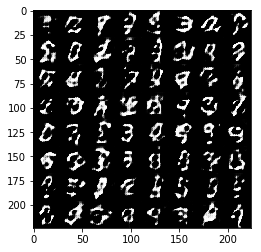

Epoch 0/2  Discriminator Loss: 1.1692   Generator Loss: 1.1122  
Epoch 0/2  Discriminator Loss: 1.1828   Generator Loss: 0.7750  
Epoch 0/2  Discriminator Loss: 1.0918   Generator Loss: 1.0193  
Epoch 0/2  Discriminator Loss: 1.1517   Generator Loss: 0.8182  
Epoch 0/2  Discriminator Loss: 1.1875   Generator Loss: 0.8603  
Epoch 0/2  Discriminator Loss: 1.1248   Generator Loss: 1.0565  
Epoch 0/2  Discriminator Loss: 1.2456   Generator Loss: 0.6484  
Epoch 0/2  Discriminator Loss: 1.1391   Generator Loss: 1.1496  
Epoch 0/2  Discriminator Loss: 1.1504   Generator Loss: 1.0951  
Epoch 0/2  Discriminator Loss: 1.1105   Generator Loss: 0.9367  


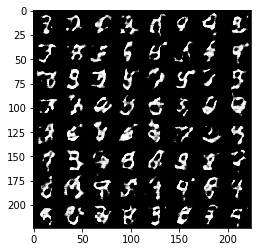

Epoch 0/2  Discriminator Loss: 1.1691   Generator Loss: 0.7829  
Epoch 0/2  Discriminator Loss: 1.1009   Generator Loss: 0.8868  
Epoch 0/2  Discriminator Loss: 1.2182   Generator Loss: 0.7771  
Epoch 0/2  Discriminator Loss: 1.1098   Generator Loss: 0.9241  
Epoch 0/2  Discriminator Loss: 1.1888   Generator Loss: 0.9442  
Epoch 0/2  Discriminator Loss: 1.3931   Generator Loss: 0.5132  
Epoch 0/2  Discriminator Loss: 1.2127   Generator Loss: 1.0557  
Epoch 0/2  Discriminator Loss: 1.2042   Generator Loss: 0.7862  
Epoch 0/2  Discriminator Loss: 1.1276   Generator Loss: 1.0542  
Epoch 0/2  Discriminator Loss: 1.2150   Generator Loss: 0.6911  


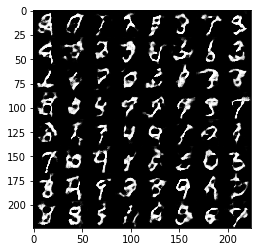

Epoch 0/2  Discriminator Loss: 1.1769   Generator Loss: 0.9796  
Epoch 0/2  Discriminator Loss: 1.2550   Generator Loss: 0.9024  
Epoch 0/2  Discriminator Loss: 1.3067   Generator Loss: 1.7517  
Epoch 0/2  Discriminator Loss: 1.1643   Generator Loss: 0.8657  
Epoch 0/2  Discriminator Loss: 1.2037   Generator Loss: 1.3125  
Epoch 0/2  Discriminator Loss: 1.2353   Generator Loss: 0.7315  
Epoch 0/2  Discriminator Loss: 1.2878   Generator Loss: 0.6164  
Epoch 0/2  Discriminator Loss: 1.2140   Generator Loss: 0.8709  
Epoch 0/2  Discriminator Loss: 1.2151   Generator Loss: 0.7516  
Epoch 0/2  Discriminator Loss: 1.2832   Generator Loss: 0.7001  


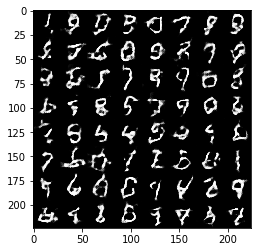

Epoch 0/2  Discriminator Loss: 1.1809   Generator Loss: 0.9491  
Epoch 0/2  Discriminator Loss: 1.2473   Generator Loss: 0.6577  
Epoch 0/2  Discriminator Loss: 1.3471   Generator Loss: 1.6870  
Epoch 0/2  Discriminator Loss: 1.1638   Generator Loss: 0.9494  
Epoch 0/2  Discriminator Loss: 1.1631   Generator Loss: 1.0186  
Epoch 0/2  Discriminator Loss: 1.2102   Generator Loss: 1.0470  
Epoch 0/2  Discriminator Loss: 1.3038   Generator Loss: 0.5958  
Epoch 0/2  Discriminator Loss: 1.1085   Generator Loss: 0.8794  
Epoch 0/2  Discriminator Loss: 1.2126   Generator Loss: 0.7352  
Epoch 0/2  Discriminator Loss: 1.2099   Generator Loss: 0.7379  


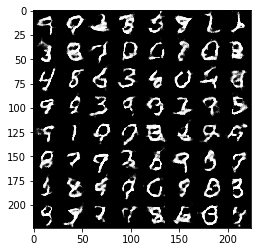

Epoch 0/2  Discriminator Loss: 1.1513   Generator Loss: 1.0102  
Epoch 0/2  Discriminator Loss: 1.1612   Generator Loss: 1.1888  
Epoch 0/2  Discriminator Loss: 1.1058   Generator Loss: 1.0066  
Epoch 0/2  Discriminator Loss: 1.1749   Generator Loss: 1.0372  
Epoch 0/2  Discriminator Loss: 1.1029   Generator Loss: 1.1142  
Epoch 0/2  Discriminator Loss: 1.3437   Generator Loss: 0.5671  
Epoch 0/2  Discriminator Loss: 1.1724   Generator Loss: 1.1857  
Epoch 0/2  Discriminator Loss: 1.2959   Generator Loss: 0.5774  
Epoch 0/2  Discriminator Loss: 1.1585   Generator Loss: 1.1413  
Epoch 0/2  Discriminator Loss: 1.3457   Generator Loss: 0.5778  


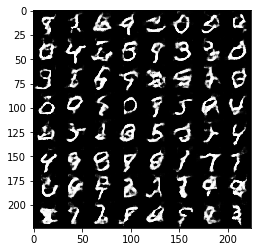

Epoch 0/2  Discriminator Loss: 1.2182   Generator Loss: 1.3460  
Epoch 0/2  Discriminator Loss: 1.1365   Generator Loss: 0.9117  
Epoch 0/2  Discriminator Loss: 1.2425   Generator Loss: 0.6822  
Epoch 0/2  Discriminator Loss: 1.2566   Generator Loss: 0.6720  
Epoch 0/2  Discriminator Loss: 1.2667   Generator Loss: 1.5711  
Epoch 0/2  Discriminator Loss: 1.2004   Generator Loss: 0.9627  
Epoch 0/2  Discriminator Loss: 1.1385   Generator Loss: 1.0560  
Epoch 0/2  Discriminator Loss: 1.1882   Generator Loss: 0.8684  
Epoch 0/2  Discriminator Loss: 1.3268   Generator Loss: 0.5971  
Epoch 0/2  Discriminator Loss: 1.2170   Generator Loss: 0.7546  


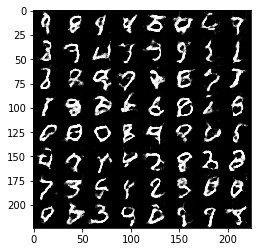

Epoch 0/2  Discriminator Loss: 1.2010   Generator Loss: 0.7133  
Epoch 0/2  Discriminator Loss: 1.1115   Generator Loss: 1.3346  
Epoch 0/2  Discriminator Loss: 1.1098   Generator Loss: 0.8574  
Epoch 1/2  Discriminator Loss: 1.2455   Generator Loss: 0.7470  
Epoch 1/2  Discriminator Loss: 1.2711   Generator Loss: 0.6632  
Epoch 1/2  Discriminator Loss: 1.1568   Generator Loss: 0.9416  
Epoch 1/2  Discriminator Loss: 1.3593   Generator Loss: 0.5567  
Epoch 1/2  Discriminator Loss: 1.2661   Generator Loss: 0.6322  
Epoch 1/2  Discriminator Loss: 1.1185   Generator Loss: 0.8861  
Epoch 1/2  Discriminator Loss: 1.1926   Generator Loss: 0.7555  


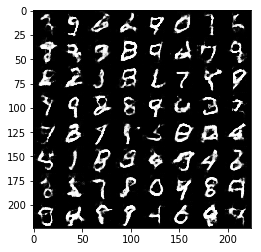

Epoch 1/2  Discriminator Loss: 1.1890   Generator Loss: 0.8323  
Epoch 1/2  Discriminator Loss: 1.3169   Generator Loss: 0.5854  
Epoch 1/2  Discriminator Loss: 1.1356   Generator Loss: 1.1050  
Epoch 1/2  Discriminator Loss: 1.1842   Generator Loss: 1.0925  
Epoch 1/2  Discriminator Loss: 1.1128   Generator Loss: 0.8470  
Epoch 1/2  Discriminator Loss: 1.2636   Generator Loss: 0.6540  
Epoch 1/2  Discriminator Loss: 1.0730   Generator Loss: 1.1843  
Epoch 1/2  Discriminator Loss: 1.1459   Generator Loss: 0.8115  
Epoch 1/2  Discriminator Loss: 1.2145   Generator Loss: 0.7710  
Epoch 1/2  Discriminator Loss: 1.1390   Generator Loss: 1.0899  


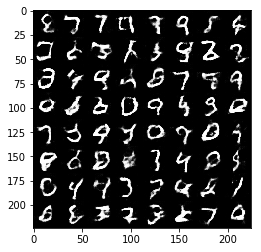

Epoch 1/2  Discriminator Loss: 1.1951   Generator Loss: 0.9042  
Epoch 1/2  Discriminator Loss: 1.1620   Generator Loss: 0.9028  
Epoch 1/2  Discriminator Loss: 1.1711   Generator Loss: 0.8887  
Epoch 1/2  Discriminator Loss: 1.1250   Generator Loss: 0.8270  
Epoch 1/2  Discriminator Loss: 1.1033   Generator Loss: 0.9650  
Epoch 1/2  Discriminator Loss: 1.0951   Generator Loss: 1.1417  
Epoch 1/2  Discriminator Loss: 1.1980   Generator Loss: 0.9331  
Epoch 1/2  Discriminator Loss: 1.1573   Generator Loss: 0.8486  
Epoch 1/2  Discriminator Loss: 1.1256   Generator Loss: 1.0820  
Epoch 1/2  Discriminator Loss: 1.3229   Generator Loss: 0.6137  


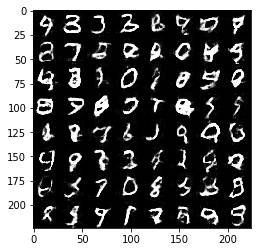

Epoch 1/2  Discriminator Loss: 1.1160   Generator Loss: 1.1835  
Epoch 1/2  Discriminator Loss: 1.2665   Generator Loss: 0.7664  
Epoch 1/2  Discriminator Loss: 1.1495   Generator Loss: 1.0238  
Epoch 1/2  Discriminator Loss: 1.1807   Generator Loss: 0.9954  
Epoch 1/2  Discriminator Loss: 1.2074   Generator Loss: 1.1314  
Epoch 1/2  Discriminator Loss: 1.3143   Generator Loss: 0.5713  
Epoch 1/2  Discriminator Loss: 1.2647   Generator Loss: 0.7288  
Epoch 1/2  Discriminator Loss: 1.2103   Generator Loss: 1.0649  
Epoch 1/2  Discriminator Loss: 1.1908   Generator Loss: 1.1703  
Epoch 1/2  Discriminator Loss: 1.2311   Generator Loss: 1.3962  


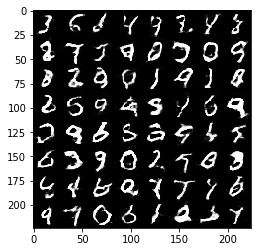

Epoch 1/2  Discriminator Loss: 1.2067   Generator Loss: 1.4316  
Epoch 1/2  Discriminator Loss: 1.1718   Generator Loss: 0.9966  
Epoch 1/2  Discriminator Loss: 1.2424   Generator Loss: 0.6689  
Epoch 1/2  Discriminator Loss: 1.2491   Generator Loss: 0.7074  
Epoch 1/2  Discriminator Loss: 1.1613   Generator Loss: 1.1989  
Epoch 1/2  Discriminator Loss: 1.3960   Generator Loss: 0.5196  
Epoch 1/2  Discriminator Loss: 1.2369   Generator Loss: 0.9098  
Epoch 1/2  Discriminator Loss: 1.2421   Generator Loss: 1.2161  
Epoch 1/2  Discriminator Loss: 1.1661   Generator Loss: 0.8545  
Epoch 1/2  Discriminator Loss: 1.1594   Generator Loss: 0.8977  


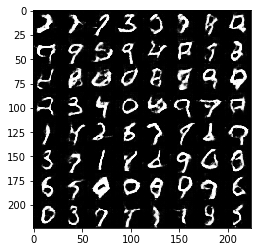

Epoch 1/2  Discriminator Loss: 1.2402   Generator Loss: 0.7600  
Epoch 1/2  Discriminator Loss: 1.2066   Generator Loss: 0.7601  
Epoch 1/2  Discriminator Loss: 1.1210   Generator Loss: 1.2154  
Epoch 1/2  Discriminator Loss: 1.1788   Generator Loss: 0.9752  
Epoch 1/2  Discriminator Loss: 1.2239   Generator Loss: 0.8392  
Epoch 1/2  Discriminator Loss: 1.1534   Generator Loss: 1.0823  
Epoch 1/2  Discriminator Loss: 1.1356   Generator Loss: 1.0027  
Epoch 1/2  Discriminator Loss: 1.2077   Generator Loss: 0.7538  
Epoch 1/2  Discriminator Loss: 1.1663   Generator Loss: 0.8876  
Epoch 1/2  Discriminator Loss: 1.2273   Generator Loss: 0.7073  


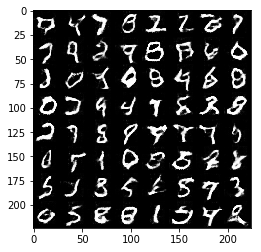

Epoch 1/2  Discriminator Loss: 1.1610   Generator Loss: 0.9797  
Epoch 1/2  Discriminator Loss: 1.2533   Generator Loss: 0.7514  
Epoch 1/2  Discriminator Loss: 1.2355   Generator Loss: 1.1976  
Epoch 1/2  Discriminator Loss: 1.2518   Generator Loss: 0.6962  
Epoch 1/2  Discriminator Loss: 1.2021   Generator Loss: 0.9305  
Epoch 1/2  Discriminator Loss: 1.2282   Generator Loss: 1.1647  
Epoch 1/2  Discriminator Loss: 1.3423   Generator Loss: 0.5648  
Epoch 1/2  Discriminator Loss: 1.2409   Generator Loss: 1.1885  
Epoch 1/2  Discriminator Loss: 1.2128   Generator Loss: 1.0052  
Epoch 1/2  Discriminator Loss: 1.3519   Generator Loss: 0.5953  


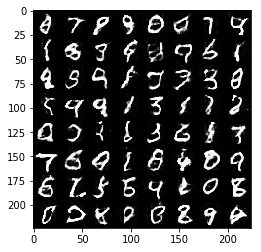

Epoch 1/2  Discriminator Loss: 1.1951   Generator Loss: 1.1629  
Epoch 1/2  Discriminator Loss: 1.2129   Generator Loss: 0.9863  
Epoch 1/2  Discriminator Loss: 1.1849   Generator Loss: 0.9040  
Epoch 1/2  Discriminator Loss: 1.2651   Generator Loss: 1.2755  
Epoch 1/2  Discriminator Loss: 1.2169   Generator Loss: 0.7222  
Epoch 1/2  Discriminator Loss: 1.1880   Generator Loss: 1.1806  
Epoch 1/2  Discriminator Loss: 1.3150   Generator Loss: 0.6319  
Epoch 1/2  Discriminator Loss: 1.1797   Generator Loss: 1.0736  
Epoch 1/2  Discriminator Loss: 1.1495   Generator Loss: 1.1694  
Epoch 1/2  Discriminator Loss: 1.2578   Generator Loss: 0.7302  


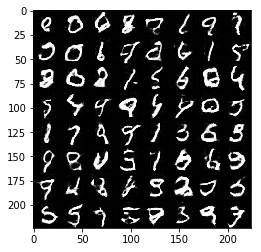

Epoch 1/2  Discriminator Loss: 1.1440   Generator Loss: 1.1398  
Epoch 1/2  Discriminator Loss: 1.1566   Generator Loss: 0.9391  
Epoch 1/2  Discriminator Loss: 1.2329   Generator Loss: 0.7705  
Epoch 1/2  Discriminator Loss: 1.1967   Generator Loss: 0.8547  
Epoch 1/2  Discriminator Loss: 1.3034   Generator Loss: 0.6277  
Epoch 1/2  Discriminator Loss: 1.2134   Generator Loss: 0.9188  
Epoch 1/2  Discriminator Loss: 1.1989   Generator Loss: 1.0777  
Epoch 1/2  Discriminator Loss: 1.1528   Generator Loss: 0.9476  
Epoch 1/2  Discriminator Loss: 1.1654   Generator Loss: 1.0493  
Epoch 1/2  Discriminator Loss: 1.2523   Generator Loss: 0.9707  


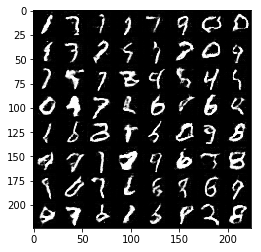

Epoch 1/2  Discriminator Loss: 1.2053   Generator Loss: 0.7445  
Epoch 1/2  Discriminator Loss: 1.1609   Generator Loss: 0.9791  
Epoch 1/2  Discriminator Loss: 1.3596   Generator Loss: 1.3184  
Epoch 1/2  Discriminator Loss: 1.2198   Generator Loss: 1.0653  
Epoch 1/2  Discriminator Loss: 1.2004   Generator Loss: 0.8280  
Epoch 1/2  Discriminator Loss: 1.1971   Generator Loss: 0.7976  
Epoch 1/2  Discriminator Loss: 1.3149   Generator Loss: 0.6345  


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 0/2  Discriminator Loss: 1.1541   Generator Loss: 0.5873  
Epoch 0/2  Discriminator Loss: 1.1958   Generator Loss: 0.5712  
Epoch 0/2  Discriminator Loss: 1.0442   Generator Loss: 0.6904  
Epoch 0/2  Discriminator Loss: 0.8627   Generator Loss: 0.9074  
Epoch 0/2  Discriminator Loss: 0.5823   Generator Loss: 1.5197  
Epoch 0/2  Discriminator Loss: 0.4188   Generator Loss: 2.5188  
Epoch 0/2  Discriminator Loss: 0.4006   Generator Loss: 2.8516  
Epoch 0/2  Discriminator Loss: 2.1537   Generator Loss: 0.2141  
Epoch 0/2  Discriminator Loss: 1.4679   Generator Loss: 0.5332  
Epoch 0/2  Discriminator Loss: 1.1222   Generator Loss: 0.9983  


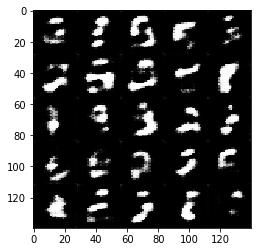

Epoch 0/2  Discriminator Loss: 1.0761   Generator Loss: 1.1891  
Epoch 0/2  Discriminator Loss: 1.0788   Generator Loss: 1.0440  
Epoch 0/2  Discriminator Loss: 1.3746   Generator Loss: 1.2247  
Epoch 0/2  Discriminator Loss: 1.2116   Generator Loss: 1.1504  
Epoch 0/2  Discriminator Loss: 1.3119   Generator Loss: 0.7606  
Epoch 0/2  Discriminator Loss: 1.3518   Generator Loss: 0.5986  
Epoch 0/2  Discriminator Loss: 1.1661   Generator Loss: 1.1862  
Epoch 0/2  Discriminator Loss: 1.3777   Generator Loss: 0.7189  
Epoch 0/2  Discriminator Loss: 1.2385   Generator Loss: 1.1510  
Epoch 0/2  Discriminator Loss: 1.2304   Generator Loss: 0.8663  


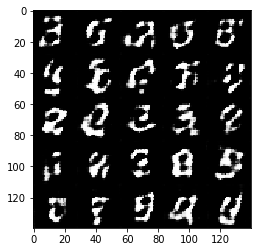

Epoch 0/2  Discriminator Loss: 1.2515   Generator Loss: 0.9462  
Epoch 0/2  Discriminator Loss: 1.0719   Generator Loss: 1.0045  
Epoch 0/2  Discriminator Loss: 1.1938   Generator Loss: 0.9125  
Epoch 0/2  Discriminator Loss: 1.3630   Generator Loss: 1.1192  
Epoch 0/2  Discriminator Loss: 1.2880   Generator Loss: 0.7360  
Epoch 0/2  Discriminator Loss: 1.1274   Generator Loss: 0.9783  
Epoch 0/2  Discriminator Loss: 1.1665   Generator Loss: 0.7958  
Epoch 0/2  Discriminator Loss: 1.2212   Generator Loss: 0.9140  
Epoch 0/2  Discriminator Loss: 1.1988   Generator Loss: 1.0551  
Epoch 0/2  Discriminator Loss: 1.1189   Generator Loss: 0.8050  


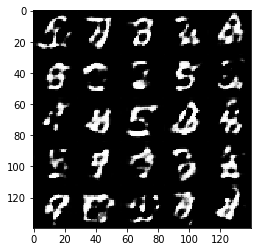

Epoch 0/2  Discriminator Loss: 1.2257   Generator Loss: 1.3974  
Epoch 0/2  Discriminator Loss: 1.2211   Generator Loss: 0.6470  
Epoch 0/2  Discriminator Loss: 1.1232   Generator Loss: 0.9591  
Epoch 0/2  Discriminator Loss: 1.2240   Generator Loss: 0.7577  
Epoch 0/2  Discriminator Loss: 1.1719   Generator Loss: 1.0451  
Epoch 0/2  Discriminator Loss: 1.1469   Generator Loss: 0.8693  
Epoch 0/2  Discriminator Loss: 1.1519   Generator Loss: 0.8876  
Epoch 0/2  Discriminator Loss: 1.1890   Generator Loss: 1.0207  
Epoch 0/2  Discriminator Loss: 1.1404   Generator Loss: 1.0660  
Epoch 0/2  Discriminator Loss: 1.2443   Generator Loss: 1.5645  


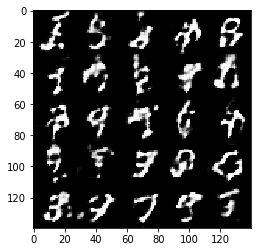

Epoch 0/2  Discriminator Loss: 1.0586   Generator Loss: 0.9899  
Epoch 0/2  Discriminator Loss: 1.2343   Generator Loss: 1.5638  
Epoch 0/2  Discriminator Loss: 1.1799   Generator Loss: 0.9838  
Epoch 0/2  Discriminator Loss: 1.1220   Generator Loss: 0.9244  
Epoch 0/2  Discriminator Loss: 1.1865   Generator Loss: 1.1399  
Epoch 0/2  Discriminator Loss: 1.2148   Generator Loss: 1.1790  
Epoch 0/2  Discriminator Loss: 1.1682   Generator Loss: 0.9610  
Epoch 0/2  Discriminator Loss: 1.1400   Generator Loss: 0.7722  
Epoch 0/2  Discriminator Loss: 1.1450   Generator Loss: 0.9181  
Epoch 0/2  Discriminator Loss: 1.1794   Generator Loss: 0.9824  


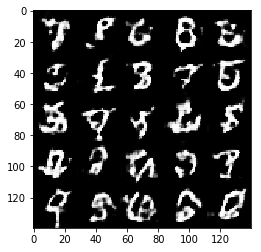

Epoch 0/2  Discriminator Loss: 1.4673   Generator Loss: 0.4651  
Epoch 0/2  Discriminator Loss: 1.2219   Generator Loss: 0.6707  
Epoch 0/2  Discriminator Loss: 1.1303   Generator Loss: 1.1340  
Epoch 0/2  Discriminator Loss: 1.2478   Generator Loss: 0.7198  
Epoch 0/2  Discriminator Loss: 1.1005   Generator Loss: 1.0833  
Epoch 0/2  Discriminator Loss: 1.2943   Generator Loss: 0.6035  
Epoch 0/2  Discriminator Loss: 1.1518   Generator Loss: 0.8977  
Epoch 0/2  Discriminator Loss: 1.2072   Generator Loss: 0.8670  
Epoch 0/2  Discriminator Loss: 1.2654   Generator Loss: 1.0788  
Epoch 0/2  Discriminator Loss: 1.3420   Generator Loss: 1.6415  


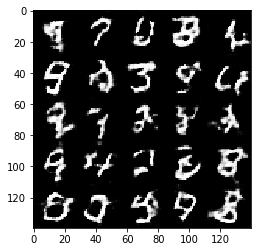

Epoch 0/2  Discriminator Loss: 1.1072   Generator Loss: 1.4051  
Epoch 0/2  Discriminator Loss: 1.2084   Generator Loss: 0.8101  
Epoch 0/2  Discriminator Loss: 1.3543   Generator Loss: 0.5751  
Epoch 0/2  Discriminator Loss: 1.1378   Generator Loss: 0.9794  
Epoch 0/2  Discriminator Loss: 1.2138   Generator Loss: 0.7006  
Epoch 0/2  Discriminator Loss: 1.5275   Generator Loss: 0.4476  
Epoch 0/2  Discriminator Loss: 1.1703   Generator Loss: 0.8715  
Epoch 0/2  Discriminator Loss: 1.1275   Generator Loss: 1.1919  
Epoch 0/2  Discriminator Loss: 1.1423   Generator Loss: 0.9357  
Epoch 0/2  Discriminator Loss: 1.2229   Generator Loss: 0.7777  


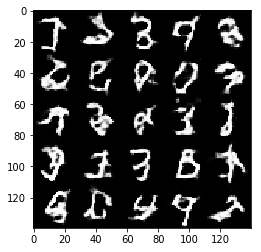

Epoch 0/2  Discriminator Loss: 1.2043   Generator Loss: 0.8803  
Epoch 0/2  Discriminator Loss: 1.2640   Generator Loss: 0.6699  
Epoch 0/2  Discriminator Loss: 1.2740   Generator Loss: 1.1243  
Epoch 0/2  Discriminator Loss: 1.2242   Generator Loss: 0.8753  
Epoch 0/2  Discriminator Loss: 1.1159   Generator Loss: 1.1185  
Epoch 0/2  Discriminator Loss: 1.1896   Generator Loss: 0.9259  
Epoch 0/2  Discriminator Loss: 1.2713   Generator Loss: 0.6443  
Epoch 0/2  Discriminator Loss: 1.2020   Generator Loss: 0.7274  
Epoch 0/2  Discriminator Loss: 1.2024   Generator Loss: 0.8357  
Epoch 0/2  Discriminator Loss: 1.1429   Generator Loss: 0.9415  


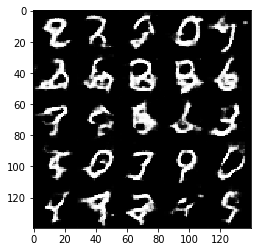

Epoch 0/2  Discriminator Loss: 1.4014   Generator Loss: 0.5618  
Epoch 0/2  Discriminator Loss: 1.3357   Generator Loss: 0.6495  
Epoch 0/2  Discriminator Loss: 1.3037   Generator Loss: 0.7009  
Epoch 0/2  Discriminator Loss: 1.2610   Generator Loss: 0.7048  
Epoch 0/2  Discriminator Loss: 1.2262   Generator Loss: 0.7235  
Epoch 0/2  Discriminator Loss: 1.2931   Generator Loss: 0.6285  
Epoch 0/2  Discriminator Loss: 1.1765   Generator Loss: 1.1753  
Epoch 0/2  Discriminator Loss: 1.1616   Generator Loss: 1.2808  
Epoch 0/2  Discriminator Loss: 1.3364   Generator Loss: 0.5798  
Epoch 0/2  Discriminator Loss: 1.2021   Generator Loss: 0.7114  


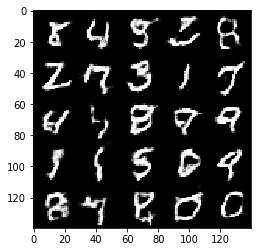

Epoch 0/2  Discriminator Loss: 1.1385   Generator Loss: 1.0657  
Epoch 0/2  Discriminator Loss: 1.3064   Generator Loss: 1.2181  
Epoch 0/2  Discriminator Loss: 1.1172   Generator Loss: 1.1923  
Epoch 0/2  Discriminator Loss: 1.0989   Generator Loss: 1.2237  
Epoch 0/2  Discriminator Loss: 1.2446   Generator Loss: 0.9216  
Epoch 0/2  Discriminator Loss: 1.4463   Generator Loss: 0.4412  
Epoch 0/2  Discriminator Loss: 1.1980   Generator Loss: 0.7052  
Epoch 0/2  Discriminator Loss: 1.1885   Generator Loss: 0.9637  
Epoch 0/2  Discriminator Loss: 1.2170   Generator Loss: 0.7671  
Epoch 0/2  Discriminator Loss: 1.1241   Generator Loss: 0.8616  


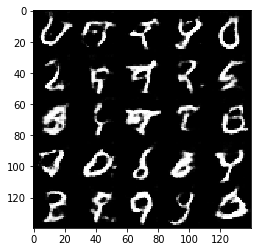

Epoch 0/2  Discriminator Loss: 1.1427   Generator Loss: 0.9340  
Epoch 0/2  Discriminator Loss: 1.2696   Generator Loss: 0.7263  
Epoch 0/2  Discriminator Loss: 1.1916   Generator Loss: 0.8456  
Epoch 0/2  Discriminator Loss: 1.2245   Generator Loss: 0.7330  
Epoch 0/2  Discriminator Loss: 1.1561   Generator Loss: 1.0394  
Epoch 0/2  Discriminator Loss: 1.2463   Generator Loss: 0.6378  
Epoch 0/2  Discriminator Loss: 1.1224   Generator Loss: 0.8085  
Epoch 0/2  Discriminator Loss: 1.1677   Generator Loss: 0.7785  
Epoch 0/2  Discriminator Loss: 1.2130   Generator Loss: 0.8076  
Epoch 0/2  Discriminator Loss: 1.1373   Generator Loss: 1.2258  


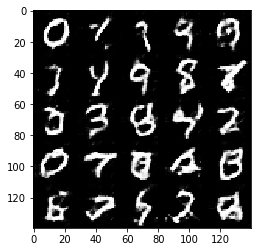

Epoch 0/2  Discriminator Loss: 1.2627   Generator Loss: 1.4132  
Epoch 0/2  Discriminator Loss: 1.2798   Generator Loss: 0.7089  
Epoch 0/2  Discriminator Loss: 1.3070   Generator Loss: 1.5847  
Epoch 0/2  Discriminator Loss: 1.1679   Generator Loss: 1.6301  
Epoch 0/2  Discriminator Loss: 1.2657   Generator Loss: 1.7521  
Epoch 0/2  Discriminator Loss: 1.1463   Generator Loss: 0.9845  
Epoch 0/2  Discriminator Loss: 1.1981   Generator Loss: 1.5379  
Epoch 0/2  Discriminator Loss: 1.1476   Generator Loss: 0.8727  
Epoch 0/2  Discriminator Loss: 1.1938   Generator Loss: 1.1283  
Epoch 0/2  Discriminator Loss: 1.3390   Generator Loss: 0.5172  


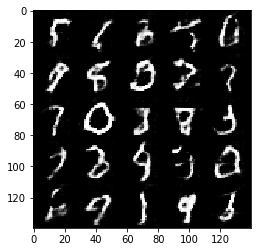

Epoch 0/2  Discriminator Loss: 1.1724   Generator Loss: 1.0225  
Epoch 0/2  Discriminator Loss: 1.2621   Generator Loss: 0.9644  
Epoch 0/2  Discriminator Loss: 1.2352   Generator Loss: 0.7620  
Epoch 0/2  Discriminator Loss: 1.3957   Generator Loss: 1.5715  
Epoch 0/2  Discriminator Loss: 1.2710   Generator Loss: 1.2334  
Epoch 0/2  Discriminator Loss: 1.2850   Generator Loss: 0.6021  
Epoch 0/2  Discriminator Loss: 1.1147   Generator Loss: 1.1358  
Epoch 0/2  Discriminator Loss: 1.2812   Generator Loss: 1.3099  
Epoch 0/2  Discriminator Loss: 1.1795   Generator Loss: 0.8846  
Epoch 0/2  Discriminator Loss: 1.2070   Generator Loss: 0.9339  


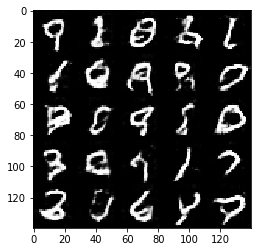

Epoch 0/2  Discriminator Loss: 1.2327   Generator Loss: 0.6904  
Epoch 0/2  Discriminator Loss: 1.2383   Generator Loss: 0.8460  
Epoch 0/2  Discriminator Loss: 1.1133   Generator Loss: 0.9611  
Epoch 0/2  Discriminator Loss: 1.3178   Generator Loss: 0.9825  
Epoch 0/2  Discriminator Loss: 1.2113   Generator Loss: 0.8536  
Epoch 0/2  Discriminator Loss: 1.1503   Generator Loss: 1.1546  
Epoch 0/2  Discriminator Loss: 1.1386   Generator Loss: 0.9879  
Epoch 0/2  Discriminator Loss: 1.1179   Generator Loss: 0.9735  
Epoch 0/2  Discriminator Loss: 1.2970   Generator Loss: 1.4735  
Epoch 0/2  Discriminator Loss: 1.3537   Generator Loss: 0.5708  


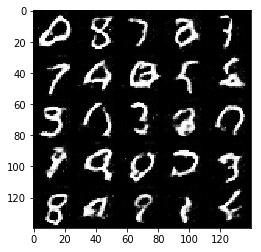

Epoch 0/2  Discriminator Loss: 1.2950   Generator Loss: 1.2039  
Epoch 0/2  Discriminator Loss: 1.1437   Generator Loss: 1.0629  
Epoch 0/2  Discriminator Loss: 1.1668   Generator Loss: 0.8880  
Epoch 0/2  Discriminator Loss: 1.1923   Generator Loss: 0.9263  
Epoch 0/2  Discriminator Loss: 1.1580   Generator Loss: 0.7341  
Epoch 0/2  Discriminator Loss: 1.0087   Generator Loss: 0.8909  
Epoch 0/2  Discriminator Loss: 1.2478   Generator Loss: 0.7067  
Epoch 0/2  Discriminator Loss: 1.0551   Generator Loss: 0.9843  
Epoch 0/2  Discriminator Loss: 1.2254   Generator Loss: 1.2464  
Epoch 0/2  Discriminator Loss: 1.1208   Generator Loss: 0.7968  


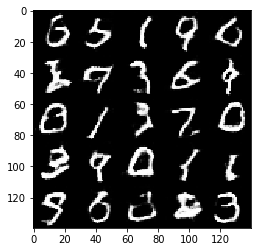

Epoch 0/2  Discriminator Loss: 1.1366   Generator Loss: 0.8628  
Epoch 0/2  Discriminator Loss: 1.2706   Generator Loss: 1.3354  
Epoch 0/2  Discriminator Loss: 1.1210   Generator Loss: 0.9577  
Epoch 0/2  Discriminator Loss: 1.0142   Generator Loss: 1.2306  
Epoch 0/2  Discriminator Loss: 1.0539   Generator Loss: 1.3321  
Epoch 0/2  Discriminator Loss: 1.2196   Generator Loss: 0.6768  
Epoch 0/2  Discriminator Loss: 1.4067   Generator Loss: 0.4790  
Epoch 0/2  Discriminator Loss: 1.2051   Generator Loss: 1.1733  
Epoch 0/2  Discriminator Loss: 1.3354   Generator Loss: 0.6034  
Epoch 0/2  Discriminator Loss: 1.2069   Generator Loss: 0.9203  


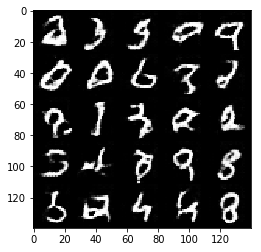

Epoch 0/2  Discriminator Loss: 1.1946   Generator Loss: 1.7123  
Epoch 0/2  Discriminator Loss: 1.2150   Generator Loss: 0.8786  
Epoch 0/2  Discriminator Loss: 1.2528   Generator Loss: 1.1930  
Epoch 0/2  Discriminator Loss: 1.3020   Generator Loss: 0.7852  
Epoch 0/2  Discriminator Loss: 1.4778   Generator Loss: 0.4684  
Epoch 0/2  Discriminator Loss: 1.2988   Generator Loss: 0.7036  
Epoch 0/2  Discriminator Loss: 1.3234   Generator Loss: 1.0374  
Epoch 0/2  Discriminator Loss: 1.2122   Generator Loss: 0.9591  
Epoch 0/2  Discriminator Loss: 1.3894   Generator Loss: 0.5473  
Epoch 0/2  Discriminator Loss: 1.1619   Generator Loss: 0.8353  


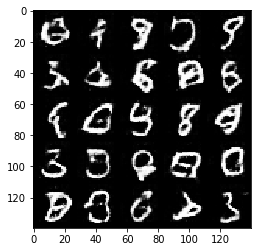

Epoch 0/2  Discriminator Loss: 1.2131   Generator Loss: 0.7495  
Epoch 0/2  Discriminator Loss: 1.2933   Generator Loss: 0.8574  
Epoch 0/2  Discriminator Loss: 1.1840   Generator Loss: 0.9928  
Epoch 0/2  Discriminator Loss: 1.2846   Generator Loss: 1.1887  
Epoch 0/2  Discriminator Loss: 1.1237   Generator Loss: 0.9296  
Epoch 0/2  Discriminator Loss: 1.1376   Generator Loss: 1.0378  
Epoch 0/2  Discriminator Loss: 1.2343   Generator Loss: 1.0319  
Epoch 0/2  Discriminator Loss: 1.2503   Generator Loss: 0.9336  
Epoch 0/2  Discriminator Loss: 1.2025   Generator Loss: 0.8679  
Epoch 0/2  Discriminator Loss: 1.4542   Generator Loss: 0.4964  


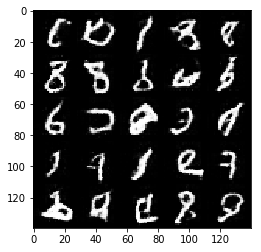

Epoch 0/2  Discriminator Loss: 1.2354   Generator Loss: 1.3913  
Epoch 0/2  Discriminator Loss: 1.3331   Generator Loss: 0.5574  
Epoch 0/2  Discriminator Loss: 1.1617   Generator Loss: 1.2478  
Epoch 0/2  Discriminator Loss: 1.2128   Generator Loss: 0.8057  
Epoch 0/2  Discriminator Loss: 1.1662   Generator Loss: 0.8266  
Epoch 0/2  Discriminator Loss: 1.0821   Generator Loss: 0.8416  
Epoch 0/2  Discriminator Loss: 1.2031   Generator Loss: 0.7709  
Epoch 1/2  Discriminator Loss: 1.2047   Generator Loss: 0.7983  
Epoch 1/2  Discriminator Loss: 1.0241   Generator Loss: 1.0560  
Epoch 1/2  Discriminator Loss: 1.0260   Generator Loss: 1.0184  


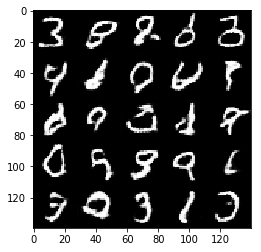

Epoch 1/2  Discriminator Loss: 1.0351   Generator Loss: 1.2978  
Epoch 1/2  Discriminator Loss: 1.2523   Generator Loss: 0.7685  
Epoch 1/2  Discriminator Loss: 1.3514   Generator Loss: 0.7578  
Epoch 1/2  Discriminator Loss: 1.1434   Generator Loss: 0.8233  
Epoch 1/2  Discriminator Loss: 1.1901   Generator Loss: 0.7753  
Epoch 1/2  Discriminator Loss: 1.2015   Generator Loss: 0.7362  
Epoch 1/2  Discriminator Loss: 1.1081   Generator Loss: 1.0439  
Epoch 1/2  Discriminator Loss: 1.0745   Generator Loss: 0.9531  
Epoch 1/2  Discriminator Loss: 0.9887   Generator Loss: 1.3187  
Epoch 1/2  Discriminator Loss: 1.2288   Generator Loss: 0.8771  


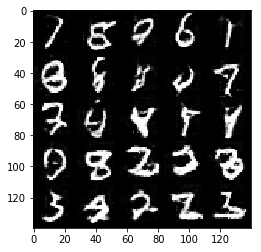

Epoch 1/2  Discriminator Loss: 1.1658   Generator Loss: 0.8450  
Epoch 1/2  Discriminator Loss: 1.2677   Generator Loss: 0.6799  
Epoch 1/2  Discriminator Loss: 1.0868   Generator Loss: 0.9698  
Epoch 1/2  Discriminator Loss: 1.1952   Generator Loss: 0.9044  
Epoch 1/2  Discriminator Loss: 1.0519   Generator Loss: 1.3254  
Epoch 1/2  Discriminator Loss: 1.2148   Generator Loss: 0.8201  
Epoch 1/2  Discriminator Loss: 1.2998   Generator Loss: 1.7047  
Epoch 1/2  Discriminator Loss: 1.1386   Generator Loss: 0.8602  
Epoch 1/2  Discriminator Loss: 1.1795   Generator Loss: 1.0895  
Epoch 1/2  Discriminator Loss: 1.0833   Generator Loss: 1.1512  


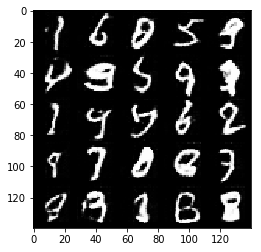

Epoch 1/2  Discriminator Loss: 1.1562   Generator Loss: 0.9065  
Epoch 1/2  Discriminator Loss: 1.1065   Generator Loss: 1.0686  
Epoch 1/2  Discriminator Loss: 1.1553   Generator Loss: 0.8690  
Epoch 1/2  Discriminator Loss: 1.2676   Generator Loss: 0.9337  
Epoch 1/2  Discriminator Loss: 1.1497   Generator Loss: 1.4255  
Epoch 1/2  Discriminator Loss: 1.1830   Generator Loss: 0.9448  
Epoch 1/2  Discriminator Loss: 1.2652   Generator Loss: 0.6319  
Epoch 1/2  Discriminator Loss: 1.0364   Generator Loss: 1.0405  
Epoch 1/2  Discriminator Loss: 1.1458   Generator Loss: 0.9960  
Epoch 1/2  Discriminator Loss: 1.0369   Generator Loss: 0.8916  


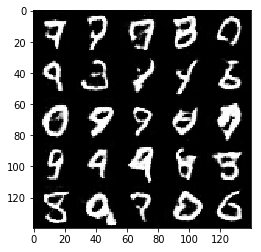

Epoch 1/2  Discriminator Loss: 1.2276   Generator Loss: 0.8259  
Epoch 1/2  Discriminator Loss: 1.0552   Generator Loss: 1.1155  
Epoch 1/2  Discriminator Loss: 1.1204   Generator Loss: 0.8434  
Epoch 1/2  Discriminator Loss: 1.2013   Generator Loss: 0.7707  
Epoch 1/2  Discriminator Loss: 1.1665   Generator Loss: 0.9211  
Epoch 1/2  Discriminator Loss: 1.2890   Generator Loss: 0.7020  
Epoch 1/2  Discriminator Loss: 1.2137   Generator Loss: 0.7557  
Epoch 1/2  Discriminator Loss: 1.2140   Generator Loss: 0.7906  
Epoch 1/2  Discriminator Loss: 1.1228   Generator Loss: 1.2550  
Epoch 1/2  Discriminator Loss: 1.0370   Generator Loss: 1.2944  


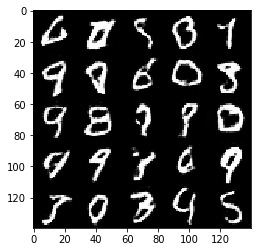

Epoch 1/2  Discriminator Loss: 1.1438   Generator Loss: 0.7611  
Epoch 1/2  Discriminator Loss: 1.1622   Generator Loss: 0.8867  
Epoch 1/2  Discriminator Loss: 1.0940   Generator Loss: 0.9326  
Epoch 1/2  Discriminator Loss: 1.2009   Generator Loss: 0.7982  
Epoch 1/2  Discriminator Loss: 1.2108   Generator Loss: 1.1298  
Epoch 1/2  Discriminator Loss: 1.2933   Generator Loss: 0.6511  
Epoch 1/2  Discriminator Loss: 1.1820   Generator Loss: 1.2011  
Epoch 1/2  Discriminator Loss: 1.1950   Generator Loss: 0.7688  
Epoch 1/2  Discriminator Loss: 1.1761   Generator Loss: 0.8807  
Epoch 1/2  Discriminator Loss: 1.2950   Generator Loss: 0.6594  


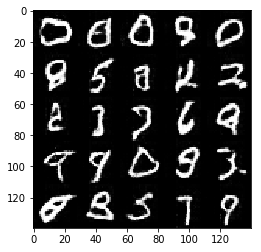

Epoch 1/2  Discriminator Loss: 1.2251   Generator Loss: 0.8170  
Epoch 1/2  Discriminator Loss: 1.1761   Generator Loss: 1.1595  
Epoch 1/2  Discriminator Loss: 1.0866   Generator Loss: 1.1306  
Epoch 1/2  Discriminator Loss: 1.0677   Generator Loss: 0.9387  
Epoch 1/2  Discriminator Loss: 1.1249   Generator Loss: 1.2447  
Epoch 1/2  Discriminator Loss: 1.0816   Generator Loss: 1.2010  
Epoch 1/2  Discriminator Loss: 1.2205   Generator Loss: 0.9816  
Epoch 1/2  Discriminator Loss: 1.1611   Generator Loss: 1.0913  
Epoch 1/2  Discriminator Loss: 1.3809   Generator Loss: 0.5934  
Epoch 1/2  Discriminator Loss: 1.0685   Generator Loss: 1.1554  


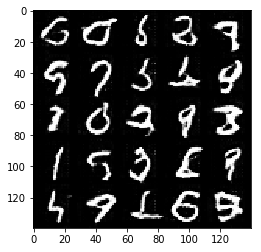

Epoch 1/2  Discriminator Loss: 1.0819   Generator Loss: 1.2283  
Epoch 1/2  Discriminator Loss: 1.1728   Generator Loss: 0.7359  
Epoch 1/2  Discriminator Loss: 1.0869   Generator Loss: 1.1259  
Epoch 1/2  Discriminator Loss: 1.1167   Generator Loss: 0.8524  
Epoch 1/2  Discriminator Loss: 1.0797   Generator Loss: 1.0193  
Epoch 1/2  Discriminator Loss: 1.0973   Generator Loss: 1.0908  
Epoch 1/2  Discriminator Loss: 1.1211   Generator Loss: 0.8594  
Epoch 1/2  Discriminator Loss: 1.1339   Generator Loss: 0.9042  
Epoch 1/2  Discriminator Loss: 1.1841   Generator Loss: 0.8498  
Epoch 1/2  Discriminator Loss: 1.1170   Generator Loss: 1.1591  


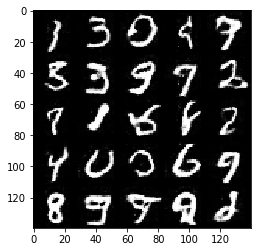

Epoch 1/2  Discriminator Loss: 1.1148   Generator Loss: 0.9829  
Epoch 1/2  Discriminator Loss: 1.1538   Generator Loss: 0.9234  
Epoch 1/2  Discriminator Loss: 1.2305   Generator Loss: 0.8274  
Epoch 1/2  Discriminator Loss: 1.2375   Generator Loss: 1.6383  
Epoch 1/2  Discriminator Loss: 1.1543   Generator Loss: 0.9349  
Epoch 1/2  Discriminator Loss: 1.1715   Generator Loss: 0.9874  
Epoch 1/2  Discriminator Loss: 1.2378   Generator Loss: 0.8156  
Epoch 1/2  Discriminator Loss: 1.0697   Generator Loss: 1.1099  
Epoch 1/2  Discriminator Loss: 0.9771   Generator Loss: 1.3111  
Epoch 1/2  Discriminator Loss: 1.0426   Generator Loss: 1.0938  


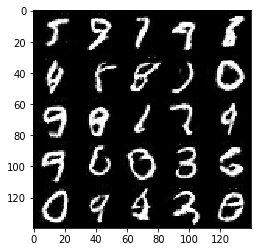

Epoch 1/2  Discriminator Loss: 1.1393   Generator Loss: 0.9032  
Epoch 1/2  Discriminator Loss: 1.1004   Generator Loss: 0.8114  
Epoch 1/2  Discriminator Loss: 1.5298   Generator Loss: 0.4806  
Epoch 1/2  Discriminator Loss: 1.3715   Generator Loss: 0.9018  
Epoch 1/2  Discriminator Loss: 1.0979   Generator Loss: 1.0936  
Epoch 1/2  Discriminator Loss: 1.0365   Generator Loss: 1.1569  
Epoch 1/2  Discriminator Loss: 1.1492   Generator Loss: 1.1045  
Epoch 1/2  Discriminator Loss: 1.2557   Generator Loss: 0.7512  
Epoch 1/2  Discriminator Loss: 1.3734   Generator Loss: 0.7557  
Epoch 1/2  Discriminator Loss: 1.1871   Generator Loss: 0.6978  


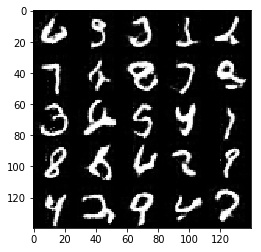

Epoch 1/2  Discriminator Loss: 1.1004   Generator Loss: 0.9653  
Epoch 1/2  Discriminator Loss: 1.2253   Generator Loss: 0.7639  
Epoch 1/2  Discriminator Loss: 1.2004   Generator Loss: 1.3546  
Epoch 1/2  Discriminator Loss: 1.2470   Generator Loss: 0.9086  
Epoch 1/2  Discriminator Loss: 1.0880   Generator Loss: 1.2564  
Epoch 1/2  Discriminator Loss: 1.1373   Generator Loss: 1.0329  
Epoch 1/2  Discriminator Loss: 1.1614   Generator Loss: 0.9525  
Epoch 1/2  Discriminator Loss: 1.1756   Generator Loss: 1.5337  
Epoch 1/2  Discriminator Loss: 1.1941   Generator Loss: 1.4899  
Epoch 1/2  Discriminator Loss: 1.1353   Generator Loss: 1.0791  


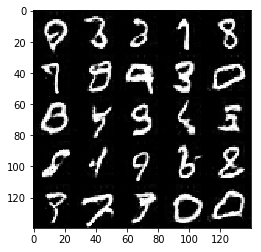

Epoch 1/2  Discriminator Loss: 0.9687   Generator Loss: 1.1188  
Epoch 1/2  Discriminator Loss: 1.1330   Generator Loss: 1.0788  
Epoch 1/2  Discriminator Loss: 1.1560   Generator Loss: 0.7688  
Epoch 1/2  Discriminator Loss: 1.0033   Generator Loss: 0.9226  
Epoch 1/2  Discriminator Loss: 1.2275   Generator Loss: 0.7841  
Epoch 1/2  Discriminator Loss: 1.0045   Generator Loss: 1.1755  
Epoch 1/2  Discriminator Loss: 1.1105   Generator Loss: 1.0091  
Epoch 1/2  Discriminator Loss: 1.1098   Generator Loss: 1.1435  
Epoch 1/2  Discriminator Loss: 1.1688   Generator Loss: 0.9764  
Epoch 1/2  Discriminator Loss: 1.1408   Generator Loss: 1.0099  


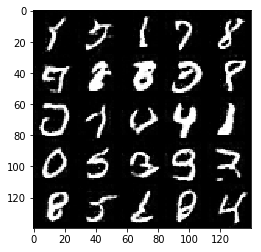

Epoch 1/2  Discriminator Loss: 1.1188   Generator Loss: 1.1095  
Epoch 1/2  Discriminator Loss: 1.1938   Generator Loss: 1.0320  
Epoch 1/2  Discriminator Loss: 1.2293   Generator Loss: 0.9025  
Epoch 1/2  Discriminator Loss: 1.1020   Generator Loss: 0.8901  
Epoch 1/2  Discriminator Loss: 1.0419   Generator Loss: 1.2575  
Epoch 1/2  Discriminator Loss: 1.0482   Generator Loss: 1.3206  
Epoch 1/2  Discriminator Loss: 1.1793   Generator Loss: 0.8405  
Epoch 1/2  Discriminator Loss: 1.0643   Generator Loss: 1.1738  
Epoch 1/2  Discriminator Loss: 1.1570   Generator Loss: 1.0069  
Epoch 1/2  Discriminator Loss: 1.0629   Generator Loss: 1.0659  


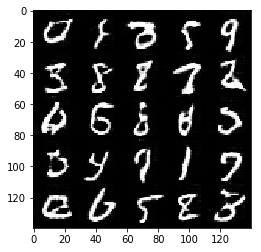

Epoch 1/2  Discriminator Loss: 1.1218   Generator Loss: 0.9910  
Epoch 1/2  Discriminator Loss: 1.2371   Generator Loss: 1.7062  
Epoch 1/2  Discriminator Loss: 1.0297   Generator Loss: 1.5305  
Epoch 1/2  Discriminator Loss: 1.2934   Generator Loss: 0.8698  
Epoch 1/2  Discriminator Loss: 1.1055   Generator Loss: 0.9938  
Epoch 1/2  Discriminator Loss: 1.2392   Generator Loss: 0.8248  
Epoch 1/2  Discriminator Loss: 1.3967   Generator Loss: 0.6382  
Epoch 1/2  Discriminator Loss: 1.1430   Generator Loss: 1.4317  
Epoch 1/2  Discriminator Loss: 1.1678   Generator Loss: 1.0072  
Epoch 1/2  Discriminator Loss: 1.2124   Generator Loss: 0.8808  


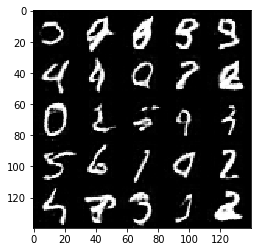

Epoch 1/2  Discriminator Loss: 1.2297   Generator Loss: 0.9208  
Epoch 1/2  Discriminator Loss: 1.1042   Generator Loss: 1.0580  
Epoch 1/2  Discriminator Loss: 1.1927   Generator Loss: 0.7398  
Epoch 1/2  Discriminator Loss: 1.3800   Generator Loss: 1.2558  
Epoch 1/2  Discriminator Loss: 1.1498   Generator Loss: 1.3701  
Epoch 1/2  Discriminator Loss: 1.3994   Generator Loss: 1.1065  
Epoch 1/2  Discriminator Loss: 1.0422   Generator Loss: 1.1177  
Epoch 1/2  Discriminator Loss: 1.1654   Generator Loss: 1.0919  
Epoch 1/2  Discriminator Loss: 1.1674   Generator Loss: 0.8778  
Epoch 1/2  Discriminator Loss: 1.2537   Generator Loss: 0.8865  


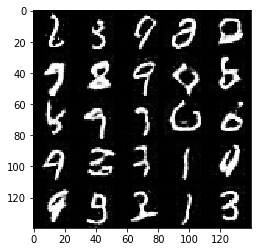

Epoch 1/2  Discriminator Loss: 1.0431   Generator Loss: 1.1332  
Epoch 1/2  Discriminator Loss: 1.0097   Generator Loss: 1.2709  
Epoch 1/2  Discriminator Loss: 1.1160   Generator Loss: 0.8730  
Epoch 1/2  Discriminator Loss: 1.2187   Generator Loss: 0.7232  
Epoch 1/2  Discriminator Loss: 1.0305   Generator Loss: 1.1005  
Epoch 1/2  Discriminator Loss: 1.2050   Generator Loss: 1.1322  
Epoch 1/2  Discriminator Loss: 1.1121   Generator Loss: 0.9135  
Epoch 1/2  Discriminator Loss: 1.0575   Generator Loss: 1.0762  
Epoch 1/2  Discriminator Loss: 1.2042   Generator Loss: 0.7809  
Epoch 1/2  Discriminator Loss: 1.2423   Generator Loss: 0.7157  


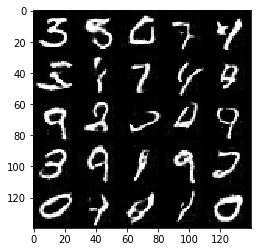

Epoch 1/2  Discriminator Loss: 1.1677   Generator Loss: 0.8932  
Epoch 1/2  Discriminator Loss: 1.0058   Generator Loss: 1.4972  
Epoch 1/2  Discriminator Loss: 1.0576   Generator Loss: 1.1334  
Epoch 1/2  Discriminator Loss: 1.0074   Generator Loss: 1.0523  
Epoch 1/2  Discriminator Loss: 1.0877   Generator Loss: 1.0792  
Epoch 1/2  Discriminator Loss: 1.2408   Generator Loss: 0.7653  
Epoch 1/2  Discriminator Loss: 1.1934   Generator Loss: 1.0563  
Epoch 1/2  Discriminator Loss: 1.0396   Generator Loss: 1.0869  
Epoch 1/2  Discriminator Loss: 0.9662   Generator Loss: 1.4471  
Epoch 1/2  Discriminator Loss: 1.2165   Generator Loss: 1.0122  


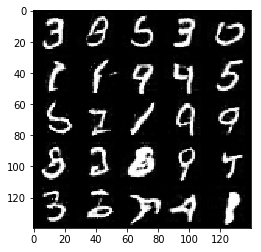

Epoch 1/2  Discriminator Loss: 1.1875   Generator Loss: 1.0520  
Epoch 1/2  Discriminator Loss: 1.1533   Generator Loss: 0.9850  
Epoch 1/2  Discriminator Loss: 1.2601   Generator Loss: 0.7186  
Epoch 1/2  Discriminator Loss: 1.0021   Generator Loss: 1.2748  
Epoch 1/2  Discriminator Loss: 1.1157   Generator Loss: 1.0478  
Epoch 1/2  Discriminator Loss: 1.1595   Generator Loss: 1.0379  
Epoch 1/2  Discriminator Loss: 1.1977   Generator Loss: 0.7886  
Epoch 1/2  Discriminator Loss: 1.1573   Generator Loss: 0.9738  
Epoch 1/2  Discriminator Loss: 1.2666   Generator Loss: 0.8347  
Epoch 1/2  Discriminator Loss: 1.1028   Generator Loss: 1.1873  


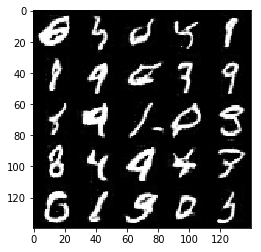

Epoch 1/2  Discriminator Loss: 1.1065   Generator Loss: 0.9754  
Epoch 1/2  Discriminator Loss: 1.0817   Generator Loss: 0.9094  
Epoch 1/2  Discriminator Loss: 1.0219   Generator Loss: 1.2118  
Epoch 1/2  Discriminator Loss: 1.1893   Generator Loss: 1.3360  
Epoch 1/2  Discriminator Loss: 1.0339   Generator Loss: 1.1242  
Epoch 1/2  Discriminator Loss: 1.2241   Generator Loss: 0.7004  
Epoch 1/2  Discriminator Loss: 1.0984   Generator Loss: 0.9232  
Epoch 1/2  Discriminator Loss: 1.0311   Generator Loss: 1.0845  
Epoch 1/2  Discriminator Loss: 1.3534   Generator Loss: 0.6443  
Epoch 1/2  Discriminator Loss: 1.0880   Generator Loss: 1.3646  


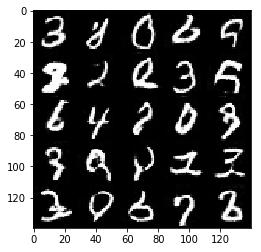

Epoch 1/2  Discriminator Loss: 1.0170   Generator Loss: 1.0447  
Epoch 1/2  Discriminator Loss: 1.0310   Generator Loss: 1.1464  
Epoch 1/2  Discriminator Loss: 1.0645   Generator Loss: 1.3303  
Epoch 1/2  Discriminator Loss: 1.1972   Generator Loss: 1.2405  
Epoch 1/2  Discriminator Loss: 1.0925   Generator Loss: 0.9210  


In [26]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1  Discriminator Loss: 1.1653   Generator Loss: 0.5880  
Epoch 0/1  Discriminator Loss: 1.1334   Generator Loss: 0.6055  
Epoch 0/1  Discriminator Loss: 1.1677   Generator Loss: 0.5886  
Epoch 0/1  Discriminator Loss: 1.0824   Generator Loss: 0.6707  
Epoch 0/1  Discriminator Loss: 0.9320   Generator Loss: 0.8308  
Epoch 0/1  Discriminator Loss: 0.7454   Generator Loss: 1.1372  
Epoch 0/1  Discriminator Loss: 0.5573   Generator Loss: 1.7346  
Epoch 0/1  Discriminator Loss: 1.4741   Generator Loss: 0.7525  
Epoch 0/1  Discriminator Loss: 1.2913   Generator Loss: 0.8253  
Epoch 0/1  Discriminator Loss: 1.2440   Generator Loss: 1.4393  


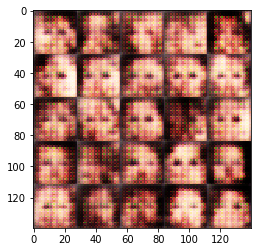

Epoch 0/1  Discriminator Loss: 1.3032   Generator Loss: 1.1157  
Epoch 0/1  Discriminator Loss: 1.4961   Generator Loss: 0.5491  
Epoch 0/1  Discriminator Loss: 1.4219   Generator Loss: 0.7555  
Epoch 0/1  Discriminator Loss: 1.4912   Generator Loss: 0.7716  
Epoch 0/1  Discriminator Loss: 1.4379   Generator Loss: 0.7614  
Epoch 0/1  Discriminator Loss: 1.4309   Generator Loss: 0.7992  
Epoch 0/1  Discriminator Loss: 1.3232   Generator Loss: 1.0044  
Epoch 0/1  Discriminator Loss: 1.4501   Generator Loss: 0.7195  
Epoch 0/1  Discriminator Loss: 1.5190   Generator Loss: 0.8572  
Epoch 0/1  Discriminator Loss: 1.3043   Generator Loss: 0.9070  


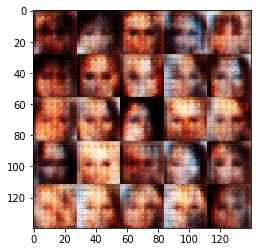

Epoch 0/1  Discriminator Loss: 1.5089   Generator Loss: 0.7760  
Epoch 0/1  Discriminator Loss: 1.3990   Generator Loss: 0.8454  
Epoch 0/1  Discriminator Loss: 1.3930   Generator Loss: 0.8390  
Epoch 0/1  Discriminator Loss: 1.4083   Generator Loss: 0.8428  
Epoch 0/1  Discriminator Loss: 1.3821   Generator Loss: 0.8120  
Epoch 0/1  Discriminator Loss: 1.3513   Generator Loss: 0.8490  
Epoch 0/1  Discriminator Loss: 1.4050   Generator Loss: 0.7479  
Epoch 0/1  Discriminator Loss: 1.4810   Generator Loss: 0.7697  
Epoch 0/1  Discriminator Loss: 1.3627   Generator Loss: 0.7607  
Epoch 0/1  Discriminator Loss: 1.5968   Generator Loss: 0.7558  


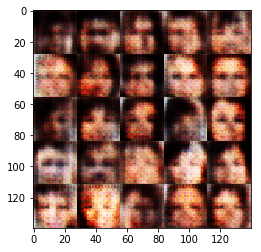

Epoch 0/1  Discriminator Loss: 1.3107   Generator Loss: 0.8061  
Epoch 0/1  Discriminator Loss: 1.3775   Generator Loss: 0.7526  
Epoch 0/1  Discriminator Loss: 1.4054   Generator Loss: 0.7125  
Epoch 0/1  Discriminator Loss: 1.3457   Generator Loss: 0.8122  
Epoch 0/1  Discriminator Loss: 1.4376   Generator Loss: 0.6972  
Epoch 0/1  Discriminator Loss: 1.3590   Generator Loss: 0.8234  
Epoch 0/1  Discriminator Loss: 1.4963   Generator Loss: 0.8200  
Epoch 0/1  Discriminator Loss: 1.4335   Generator Loss: 0.7814  
Epoch 0/1  Discriminator Loss: 1.4674   Generator Loss: 0.6710  
Epoch 0/1  Discriminator Loss: 1.3477   Generator Loss: 0.7810  


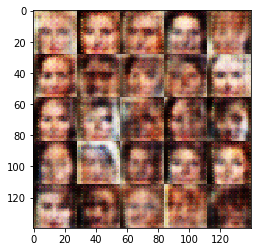

Epoch 0/1  Discriminator Loss: 1.4449   Generator Loss: 0.6852  
Epoch 0/1  Discriminator Loss: 1.4359   Generator Loss: 0.7564  
Epoch 0/1  Discriminator Loss: 1.4260   Generator Loss: 0.7518  
Epoch 0/1  Discriminator Loss: 1.4829   Generator Loss: 0.7296  
Epoch 0/1  Discriminator Loss: 1.4243   Generator Loss: 0.7379  
Epoch 0/1  Discriminator Loss: 1.5266   Generator Loss: 0.7130  
Epoch 0/1  Discriminator Loss: 1.4151   Generator Loss: 0.7867  
Epoch 0/1  Discriminator Loss: 1.3951   Generator Loss: 0.8159  
Epoch 0/1  Discriminator Loss: 1.4763   Generator Loss: 0.7622  
Epoch 0/1  Discriminator Loss: 1.3679   Generator Loss: 0.8475  


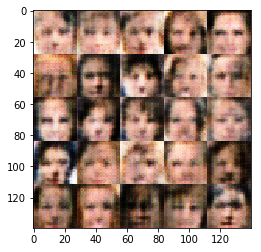

Epoch 0/1  Discriminator Loss: 1.3925   Generator Loss: 0.8241  
Epoch 0/1  Discriminator Loss: 1.4043   Generator Loss: 0.7373  
Epoch 0/1  Discriminator Loss: 1.5069   Generator Loss: 0.7467  
Epoch 0/1  Discriminator Loss: 1.5053   Generator Loss: 0.7241  
Epoch 0/1  Discriminator Loss: 1.3981   Generator Loss: 0.8331  
Epoch 0/1  Discriminator Loss: 1.4414   Generator Loss: 0.7598  
Epoch 0/1  Discriminator Loss: 1.5184   Generator Loss: 0.7677  
Epoch 0/1  Discriminator Loss: 1.3173   Generator Loss: 0.7699  
Epoch 0/1  Discriminator Loss: 1.4179   Generator Loss: 0.7799  
Epoch 0/1  Discriminator Loss: 1.4074   Generator Loss: 0.7337  


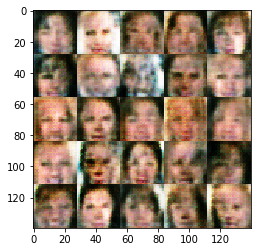

Epoch 0/1  Discriminator Loss: 1.4040   Generator Loss: 0.8259  
Epoch 0/1  Discriminator Loss: 1.3606   Generator Loss: 0.7667  
Epoch 0/1  Discriminator Loss: 1.3825   Generator Loss: 0.7468  
Epoch 0/1  Discriminator Loss: 1.4111   Generator Loss: 0.7237  
Epoch 0/1  Discriminator Loss: 1.3798   Generator Loss: 0.7874  
Epoch 0/1  Discriminator Loss: 1.4368   Generator Loss: 0.7040  
Epoch 0/1  Discriminator Loss: 1.4076   Generator Loss: 0.7826  
Epoch 0/1  Discriminator Loss: 1.3874   Generator Loss: 0.8372  
Epoch 0/1  Discriminator Loss: 1.4118   Generator Loss: 0.8275  
Epoch 0/1  Discriminator Loss: 1.3640   Generator Loss: 0.7776  


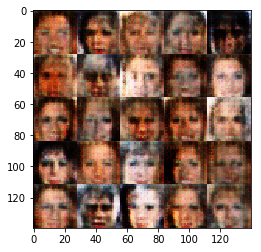

Epoch 0/1  Discriminator Loss: 1.4075   Generator Loss: 0.8016  
Epoch 0/1  Discriminator Loss: 1.3813   Generator Loss: 0.7530  
Epoch 0/1  Discriminator Loss: 1.3864   Generator Loss: 0.7559  
Epoch 0/1  Discriminator Loss: 1.3866   Generator Loss: 0.8013  
Epoch 0/1  Discriminator Loss: 1.4318   Generator Loss: 0.7380  
Epoch 0/1  Discriminator Loss: 1.4192   Generator Loss: 0.7619  
Epoch 0/1  Discriminator Loss: 1.3578   Generator Loss: 0.7887  
Epoch 0/1  Discriminator Loss: 1.4450   Generator Loss: 0.7361  
Epoch 0/1  Discriminator Loss: 1.3248   Generator Loss: 0.8137  
Epoch 0/1  Discriminator Loss: 1.4899   Generator Loss: 0.7437  


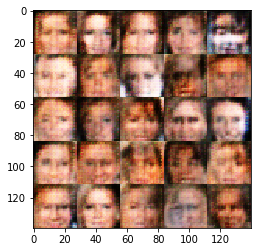

Epoch 0/1  Discriminator Loss: 1.3508   Generator Loss: 0.7962  
Epoch 0/1  Discriminator Loss: 1.4656   Generator Loss: 0.7118  
Epoch 0/1  Discriminator Loss: 1.4348   Generator Loss: 0.7887  
Epoch 0/1  Discriminator Loss: 1.4211   Generator Loss: 0.7709  
Epoch 0/1  Discriminator Loss: 1.3750   Generator Loss: 0.8127  
Epoch 0/1  Discriminator Loss: 1.4375   Generator Loss: 0.7406  
Epoch 0/1  Discriminator Loss: 1.4437   Generator Loss: 0.8158  
Epoch 0/1  Discriminator Loss: 1.3259   Generator Loss: 0.7969  
Epoch 0/1  Discriminator Loss: 1.3740   Generator Loss: 0.7912  
Epoch 0/1  Discriminator Loss: 1.4125   Generator Loss: 0.8103  


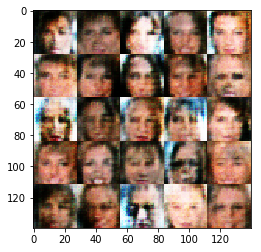

Epoch 0/1  Discriminator Loss: 1.3804   Generator Loss: 0.7867  
Epoch 0/1  Discriminator Loss: 1.3878   Generator Loss: 0.8626  
Epoch 0/1  Discriminator Loss: 1.4093   Generator Loss: 0.7671  
Epoch 0/1  Discriminator Loss: 1.4041   Generator Loss: 0.7913  
Epoch 0/1  Discriminator Loss: 1.4131   Generator Loss: 0.8122  
Epoch 0/1  Discriminator Loss: 1.4482   Generator Loss: 0.7329  
Epoch 0/1  Discriminator Loss: 1.4440   Generator Loss: 0.7287  
Epoch 0/1  Discriminator Loss: 1.3117   Generator Loss: 0.8745  
Epoch 0/1  Discriminator Loss: 1.4014   Generator Loss: 0.8274  
Epoch 0/1  Discriminator Loss: 1.3833   Generator Loss: 0.7402  


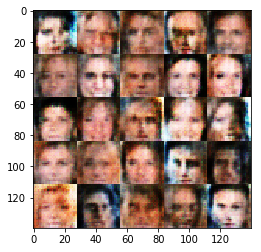

Epoch 0/1  Discriminator Loss: 1.4580   Generator Loss: 0.7852  
Epoch 0/1  Discriminator Loss: 1.3241   Generator Loss: 0.7933  
Epoch 0/1  Discriminator Loss: 1.3545   Generator Loss: 0.8505  
Epoch 0/1  Discriminator Loss: 1.4362   Generator Loss: 0.8280  
Epoch 0/1  Discriminator Loss: 1.4031   Generator Loss: 0.8085  
Epoch 0/1  Discriminator Loss: 1.3505   Generator Loss: 0.7629  
Epoch 0/1  Discriminator Loss: 1.3260   Generator Loss: 0.7832  
Epoch 0/1  Discriminator Loss: 1.3773   Generator Loss: 0.8167  
Epoch 0/1  Discriminator Loss: 1.3962   Generator Loss: 0.7775  
Epoch 0/1  Discriminator Loss: 1.3517   Generator Loss: 0.7884  


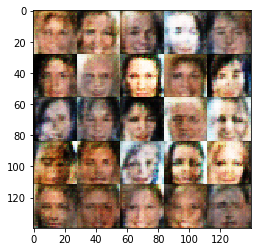

Epoch 0/1  Discriminator Loss: 1.3774   Generator Loss: 0.8142  
Epoch 0/1  Discriminator Loss: 1.3331   Generator Loss: 0.8219  
Epoch 0/1  Discriminator Loss: 1.3363   Generator Loss: 0.8014  
Epoch 0/1  Discriminator Loss: 1.4436   Generator Loss: 0.7128  
Epoch 0/1  Discriminator Loss: 1.3606   Generator Loss: 0.7808  
Epoch 0/1  Discriminator Loss: 1.3818   Generator Loss: 0.8152  
Epoch 0/1  Discriminator Loss: 1.4604   Generator Loss: 0.7203  
Epoch 0/1  Discriminator Loss: 1.3642   Generator Loss: 0.7992  
Epoch 0/1  Discriminator Loss: 1.4149   Generator Loss: 0.7869  
Epoch 0/1  Discriminator Loss: 1.4360   Generator Loss: 0.7441  


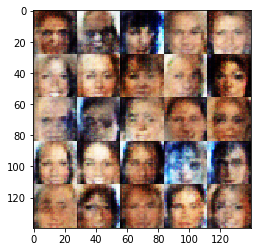

Epoch 0/1  Discriminator Loss: 1.3921   Generator Loss: 0.7957  
Epoch 0/1  Discriminator Loss: 1.3894   Generator Loss: 0.7886  
Epoch 0/1  Discriminator Loss: 1.4718   Generator Loss: 0.7167  
Epoch 0/1  Discriminator Loss: 1.3856   Generator Loss: 0.7756  
Epoch 0/1  Discriminator Loss: 1.3606   Generator Loss: 0.8223  
Epoch 0/1  Discriminator Loss: 1.4084   Generator Loss: 0.7777  
Epoch 0/1  Discriminator Loss: 1.3526   Generator Loss: 0.7690  
Epoch 0/1  Discriminator Loss: 1.4014   Generator Loss: 0.7668  
Epoch 0/1  Discriminator Loss: 1.3835   Generator Loss: 0.7998  
Epoch 0/1  Discriminator Loss: 1.4189   Generator Loss: 0.7895  


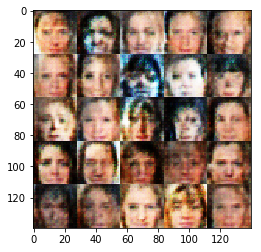

Epoch 0/1  Discriminator Loss: 1.4498   Generator Loss: 0.7568  
Epoch 0/1  Discriminator Loss: 1.3789   Generator Loss: 0.8173  
Epoch 0/1  Discriminator Loss: 1.3843   Generator Loss: 0.7882  
Epoch 0/1  Discriminator Loss: 1.3699   Generator Loss: 0.7718  
Epoch 0/1  Discriminator Loss: 1.4265   Generator Loss: 0.7791  
Epoch 0/1  Discriminator Loss: 1.3641   Generator Loss: 0.8055  
Epoch 0/1  Discriminator Loss: 1.4324   Generator Loss: 0.7824  
Epoch 0/1  Discriminator Loss: 1.3957   Generator Loss: 0.7981  
Epoch 0/1  Discriminator Loss: 1.3650   Generator Loss: 0.7973  
Epoch 0/1  Discriminator Loss: 1.3359   Generator Loss: 0.8043  


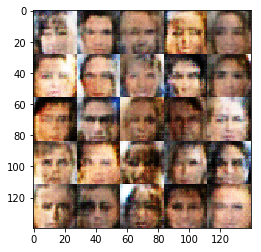

Epoch 0/1  Discriminator Loss: 1.4478   Generator Loss: 0.7441  
Epoch 0/1  Discriminator Loss: 1.3687   Generator Loss: 0.8235  
Epoch 0/1  Discriminator Loss: 1.3764   Generator Loss: 0.7902  
Epoch 0/1  Discriminator Loss: 1.4133   Generator Loss: 0.7398  
Epoch 0/1  Discriminator Loss: 1.3982   Generator Loss: 0.8020  
Epoch 0/1  Discriminator Loss: 1.4403   Generator Loss: 0.7327  
Epoch 0/1  Discriminator Loss: 1.4068   Generator Loss: 0.7693  
Epoch 0/1  Discriminator Loss: 1.4037   Generator Loss: 0.7607  
Epoch 0/1  Discriminator Loss: 1.4252   Generator Loss: 0.7573  
Epoch 0/1  Discriminator Loss: 1.3564   Generator Loss: 0.8336  


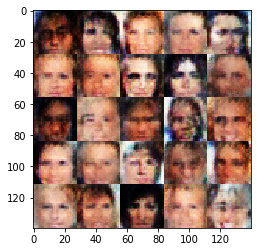

Epoch 0/1  Discriminator Loss: 1.3889   Generator Loss: 0.8005  
Epoch 0/1  Discriminator Loss: 1.3731   Generator Loss: 0.8044  
Epoch 0/1  Discriminator Loss: 1.4089   Generator Loss: 0.7521  
Epoch 0/1  Discriminator Loss: 1.4016   Generator Loss: 0.7619  
Epoch 0/1  Discriminator Loss: 1.3837   Generator Loss: 0.8186  
Epoch 0/1  Discriminator Loss: 1.3786   Generator Loss: 0.8251  
Epoch 0/1  Discriminator Loss: 1.3566   Generator Loss: 0.8268  
Epoch 0/1  Discriminator Loss: 1.4188   Generator Loss: 0.7576  
Epoch 0/1  Discriminator Loss: 1.4126   Generator Loss: 0.7788  
Epoch 0/1  Discriminator Loss: 1.4073   Generator Loss: 0.7732  


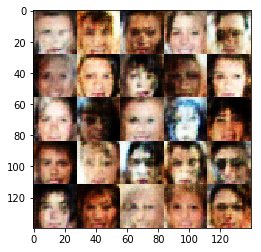

Epoch 0/1  Discriminator Loss: 1.3922   Generator Loss: 0.7765  
Epoch 0/1  Discriminator Loss: 1.3800   Generator Loss: 0.7817  
Epoch 0/1  Discriminator Loss: 1.4407   Generator Loss: 0.7224  
Epoch 0/1  Discriminator Loss: 1.3868   Generator Loss: 0.8033  
Epoch 0/1  Discriminator Loss: 1.3841   Generator Loss: 0.7662  
Epoch 0/1  Discriminator Loss: 1.3535   Generator Loss: 0.7898  
Epoch 0/1  Discriminator Loss: 1.3369   Generator Loss: 0.8123  
Epoch 0/1  Discriminator Loss: 1.3922   Generator Loss: 0.7901  
Epoch 0/1  Discriminator Loss: 1.4015   Generator Loss: 0.7786  
Epoch 0/1  Discriminator Loss: 1.3453   Generator Loss: 0.7721  


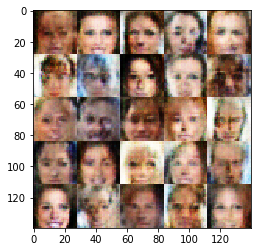

Epoch 0/1  Discriminator Loss: 1.4180   Generator Loss: 0.7730  
Epoch 0/1  Discriminator Loss: 1.3599   Generator Loss: 0.8384  
Epoch 0/1  Discriminator Loss: 1.4196   Generator Loss: 0.8119  
Epoch 0/1  Discriminator Loss: 1.4036   Generator Loss: 0.7944  
Epoch 0/1  Discriminator Loss: 1.3732   Generator Loss: 0.7745  
Epoch 0/1  Discriminator Loss: 1.3997   Generator Loss: 0.7760  
Epoch 0/1  Discriminator Loss: 1.4114   Generator Loss: 0.7740  
Epoch 0/1  Discriminator Loss: 1.4732   Generator Loss: 0.7506  
Epoch 0/1  Discriminator Loss: 1.3551   Generator Loss: 0.7659  
Epoch 0/1  Discriminator Loss: 1.4185   Generator Loss: 0.8116  


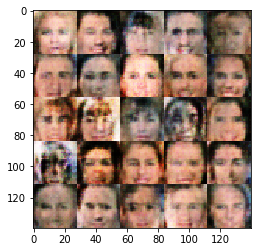

Epoch 0/1  Discriminator Loss: 1.4510   Generator Loss: 0.7715  
Epoch 0/1  Discriminator Loss: 1.4124   Generator Loss: 0.7925  
Epoch 0/1  Discriminator Loss: 1.3522   Generator Loss: 0.7527  
Epoch 0/1  Discriminator Loss: 1.4449   Generator Loss: 0.7392  
Epoch 0/1  Discriminator Loss: 1.3452   Generator Loss: 0.7803  
Epoch 0/1  Discriminator Loss: 1.4164   Generator Loss: 0.7901  
Epoch 0/1  Discriminator Loss: 1.3816   Generator Loss: 0.8086  
Epoch 0/1  Discriminator Loss: 1.4367   Generator Loss: 0.7545  
Epoch 0/1  Discriminator Loss: 1.4090   Generator Loss: 0.7849  
Epoch 0/1  Discriminator Loss: 1.3943   Generator Loss: 0.7815  


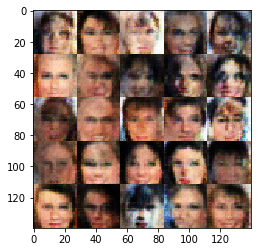

Epoch 0/1  Discriminator Loss: 1.4065   Generator Loss: 0.7850  
Epoch 0/1  Discriminator Loss: 1.3324   Generator Loss: 0.8142  
Epoch 0/1  Discriminator Loss: 1.3980   Generator Loss: 0.7707  
Epoch 0/1  Discriminator Loss: 1.3924   Generator Loss: 0.7622  
Epoch 0/1  Discriminator Loss: 1.4118   Generator Loss: 0.7780  
Epoch 0/1  Discriminator Loss: 1.4165   Generator Loss: 0.7394  
Epoch 0/1  Discriminator Loss: 1.3874   Generator Loss: 0.7763  
Epoch 0/1  Discriminator Loss: 1.3816   Generator Loss: 0.7521  
Epoch 0/1  Discriminator Loss: 1.3559   Generator Loss: 0.7894  
Epoch 0/1  Discriminator Loss: 1.3727   Generator Loss: 0.7626  


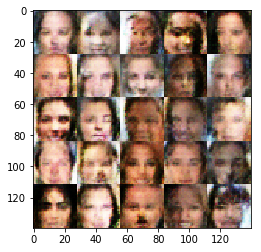

Epoch 0/1  Discriminator Loss: 1.4203   Generator Loss: 0.7970  
Epoch 0/1  Discriminator Loss: 1.3864   Generator Loss: 0.7531  
Epoch 0/1  Discriminator Loss: 1.3732   Generator Loss: 0.8141  
Epoch 0/1  Discriminator Loss: 1.3668   Generator Loss: 0.7594  
Epoch 0/1  Discriminator Loss: 1.3708   Generator Loss: 0.8161  
Epoch 0/1  Discriminator Loss: 1.4843   Generator Loss: 0.7557  
Epoch 0/1  Discriminator Loss: 1.3562   Generator Loss: 0.7957  
Epoch 0/1  Discriminator Loss: 1.4300   Generator Loss: 0.7578  
Epoch 0/1  Discriminator Loss: 1.4426   Generator Loss: 0.7783  
Epoch 0/1  Discriminator Loss: 1.3745   Generator Loss: 0.8148  


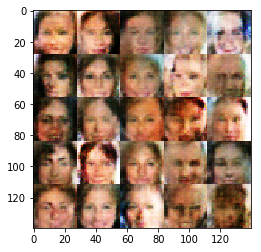

Epoch 0/1  Discriminator Loss: 1.3785   Generator Loss: 0.7665  
Epoch 0/1  Discriminator Loss: 1.4005   Generator Loss: 0.7349  
Epoch 0/1  Discriminator Loss: 1.3827   Generator Loss: 0.7883  
Epoch 0/1  Discriminator Loss: 1.3786   Generator Loss: 0.7939  
Epoch 0/1  Discriminator Loss: 1.3509   Generator Loss: 0.8114  
Epoch 0/1  Discriminator Loss: 1.3458   Generator Loss: 0.8265  
Epoch 0/1  Discriminator Loss: 1.3581   Generator Loss: 0.8276  
Epoch 0/1  Discriminator Loss: 1.3286   Generator Loss: 0.8319  
Epoch 0/1  Discriminator Loss: 1.3981   Generator Loss: 0.7893  
Epoch 0/1  Discriminator Loss: 1.4098   Generator Loss: 0.7467  


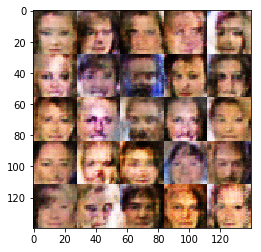

Epoch 0/1  Discriminator Loss: 1.3779   Generator Loss: 0.7641  
Epoch 0/1  Discriminator Loss: 1.4349   Generator Loss: 0.7347  
Epoch 0/1  Discriminator Loss: 1.3811   Generator Loss: 0.8259  
Epoch 0/1  Discriminator Loss: 1.4113   Generator Loss: 0.7697  
Epoch 0/1  Discriminator Loss: 1.3998   Generator Loss: 0.7508  
Epoch 0/1  Discriminator Loss: 1.4074   Generator Loss: 0.7774  
Epoch 0/1  Discriminator Loss: 1.4397   Generator Loss: 0.7594  
Epoch 0/1  Discriminator Loss: 1.3227   Generator Loss: 0.8572  
Epoch 0/1  Discriminator Loss: 1.4335   Generator Loss: 0.7536  
Epoch 0/1  Discriminator Loss: 1.3693   Generator Loss: 0.8076  


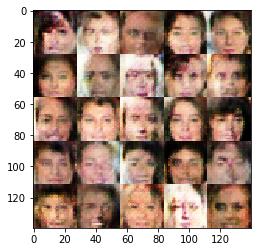

Epoch 0/1  Discriminator Loss: 1.3904   Generator Loss: 0.7677  
Epoch 0/1  Discriminator Loss: 1.4108   Generator Loss: 0.7424  
Epoch 0/1  Discriminator Loss: 1.4134   Generator Loss: 0.7409  
Epoch 0/1  Discriminator Loss: 1.3670   Generator Loss: 0.7660  
Epoch 0/1  Discriminator Loss: 1.3807   Generator Loss: 0.7606  
Epoch 0/1  Discriminator Loss: 1.3916   Generator Loss: 0.8137  
Epoch 0/1  Discriminator Loss: 1.4050   Generator Loss: 0.7850  
Epoch 0/1  Discriminator Loss: 1.3651   Generator Loss: 0.7820  
Epoch 0/1  Discriminator Loss: 1.3921   Generator Loss: 0.7936  
Epoch 0/1  Discriminator Loss: 1.4091   Generator Loss: 0.7691  


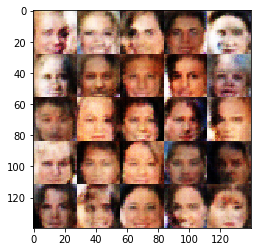

Epoch 0/1  Discriminator Loss: 1.4156   Generator Loss: 0.7683  
Epoch 0/1  Discriminator Loss: 1.4004   Generator Loss: 0.7879  
Epoch 0/1  Discriminator Loss: 1.4365   Generator Loss: 0.7769  
Epoch 0/1  Discriminator Loss: 1.3657   Generator Loss: 0.8031  
Epoch 0/1  Discriminator Loss: 1.4057   Generator Loss: 0.7790  
Epoch 0/1  Discriminator Loss: 1.4418   Generator Loss: 0.7462  
Epoch 0/1  Discriminator Loss: 1.3465   Generator Loss: 0.8274  
Epoch 0/1  Discriminator Loss: 1.3963   Generator Loss: 0.7722  
Epoch 0/1  Discriminator Loss: 1.4030   Generator Loss: 0.7943  
Epoch 0/1  Discriminator Loss: 1.4181   Generator Loss: 0.7666  


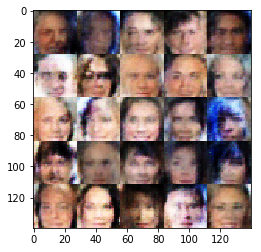

Epoch 0/1  Discriminator Loss: 1.3692   Generator Loss: 0.7673  
Epoch 0/1  Discriminator Loss: 1.4143   Generator Loss: 0.8088  
Epoch 0/1  Discriminator Loss: 1.3915   Generator Loss: 0.8060  
Epoch 0/1  Discriminator Loss: 1.3919   Generator Loss: 0.8152  
Epoch 0/1  Discriminator Loss: 1.3819   Generator Loss: 0.7629  
Epoch 0/1  Discriminator Loss: 1.4134   Generator Loss: 0.7615  
Epoch 0/1  Discriminator Loss: 1.4492   Generator Loss: 0.7435  
Epoch 0/1  Discriminator Loss: 1.3538   Generator Loss: 0.8347  
Epoch 0/1  Discriminator Loss: 1.3831   Generator Loss: 0.7699  
Epoch 0/1  Discriminator Loss: 1.3716   Generator Loss: 0.7791  


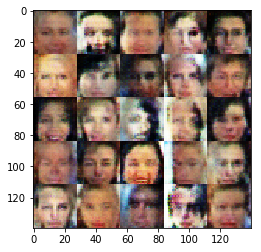

Epoch 0/1  Discriminator Loss: 1.4550   Generator Loss: 0.7899  
Epoch 0/1  Discriminator Loss: 1.3561   Generator Loss: 0.7674  
Epoch 0/1  Discriminator Loss: 1.4212   Generator Loss: 0.7346  
Epoch 0/1  Discriminator Loss: 1.3870   Generator Loss: 0.7820  
Epoch 0/1  Discriminator Loss: 1.3653   Generator Loss: 0.7930  
Epoch 0/1  Discriminator Loss: 1.4017   Generator Loss: 0.7584  
Epoch 0/1  Discriminator Loss: 1.4210   Generator Loss: 0.7858  
Epoch 0/1  Discriminator Loss: 1.4012   Generator Loss: 0.8076  
Epoch 0/1  Discriminator Loss: 1.3709   Generator Loss: 0.8080  
Epoch 0/1  Discriminator Loss: 1.4101   Generator Loss: 0.8002  


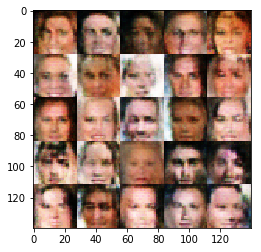

Epoch 0/1  Discriminator Loss: 1.4488   Generator Loss: 0.7316  
Epoch 0/1  Discriminator Loss: 1.3975   Generator Loss: 0.7690  
Epoch 0/1  Discriminator Loss: 1.3964   Generator Loss: 0.8025  
Epoch 0/1  Discriminator Loss: 1.3671   Generator Loss: 0.7896  
Epoch 0/1  Discriminator Loss: 1.3869   Generator Loss: 0.7600  
Epoch 0/1  Discriminator Loss: 1.3855   Generator Loss: 0.8153  
Epoch 0/1  Discriminator Loss: 1.4251   Generator Loss: 0.7505  
Epoch 0/1  Discriminator Loss: 1.3674   Generator Loss: 0.8019  
Epoch 0/1  Discriminator Loss: 1.4382   Generator Loss: 0.7558  
Epoch 0/1  Discriminator Loss: 1.4106   Generator Loss: 0.7669  


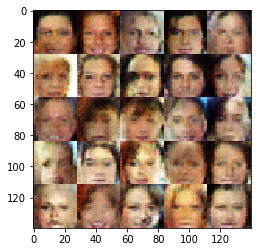

Epoch 0/1  Discriminator Loss: 1.3797   Generator Loss: 0.8295  
Epoch 0/1  Discriminator Loss: 1.3827   Generator Loss: 0.7698  
Epoch 0/1  Discriminator Loss: 1.4220   Generator Loss: 0.7418  
Epoch 0/1  Discriminator Loss: 1.4098   Generator Loss: 0.7865  
Epoch 0/1  Discriminator Loss: 1.3330   Generator Loss: 0.8169  
Epoch 0/1  Discriminator Loss: 1.3266   Generator Loss: 0.8251  
Epoch 0/1  Discriminator Loss: 1.3638   Generator Loss: 0.8033  
Epoch 0/1  Discriminator Loss: 1.3807   Generator Loss: 0.7870  
Epoch 0/1  Discriminator Loss: 1.3900   Generator Loss: 0.7726  
Epoch 0/1  Discriminator Loss: 1.3811   Generator Loss: 0.7863  


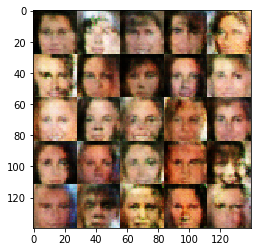

Epoch 0/1  Discriminator Loss: 1.4072   Generator Loss: 0.7489  
Epoch 0/1  Discriminator Loss: 1.4287   Generator Loss: 0.8014  
Epoch 0/1  Discriminator Loss: 1.3367   Generator Loss: 0.7903  
Epoch 0/1  Discriminator Loss: 1.3458   Generator Loss: 0.8028  
Epoch 0/1  Discriminator Loss: 1.4189   Generator Loss: 0.7688  
Epoch 0/1  Discriminator Loss: 1.3876   Generator Loss: 0.7482  
Epoch 0/1  Discriminator Loss: 1.3855   Generator Loss: 0.7968  
Epoch 0/1  Discriminator Loss: 1.3864   Generator Loss: 0.8021  
Epoch 0/1  Discriminator Loss: 1.4360   Generator Loss: 0.7660  
Epoch 0/1  Discriminator Loss: 1.3605   Generator Loss: 0.7858  


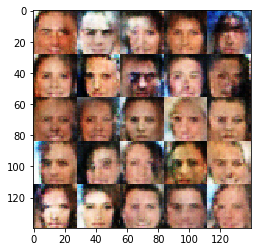

Epoch 0/1  Discriminator Loss: 1.4335   Generator Loss: 0.7809  
Epoch 0/1  Discriminator Loss: 1.3688   Generator Loss: 0.8108  
Epoch 0/1  Discriminator Loss: 1.3341   Generator Loss: 0.7983  
Epoch 0/1  Discriminator Loss: 1.3912   Generator Loss: 0.7828  
Epoch 0/1  Discriminator Loss: 1.3945   Generator Loss: 0.7878  
Epoch 0/1  Discriminator Loss: 1.3915   Generator Loss: 0.7723  
Epoch 0/1  Discriminator Loss: 1.3928   Generator Loss: 0.8044  
Epoch 0/1  Discriminator Loss: 1.3510   Generator Loss: 0.8338  
Epoch 0/1  Discriminator Loss: 1.3659   Generator Loss: 0.8180  
Epoch 0/1  Discriminator Loss: 1.3805   Generator Loss: 0.8213  


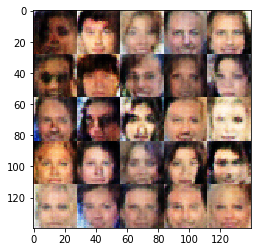

Epoch 0/1  Discriminator Loss: 1.3161   Generator Loss: 0.8271  
Epoch 0/1  Discriminator Loss: 1.3957   Generator Loss: 0.7572  
Epoch 0/1  Discriminator Loss: 1.3747   Generator Loss: 0.7863  
Epoch 0/1  Discriminator Loss: 1.4167   Generator Loss: 0.8031  
Epoch 0/1  Discriminator Loss: 1.3554   Generator Loss: 0.8027  
Epoch 0/1  Discriminator Loss: 1.3455   Generator Loss: 0.7851  
Epoch 0/1  Discriminator Loss: 1.3847   Generator Loss: 0.7733  
Epoch 0/1  Discriminator Loss: 1.4065   Generator Loss: 0.7782  
Epoch 0/1  Discriminator Loss: 1.3524   Generator Loss: 0.8224  
Epoch 0/1  Discriminator Loss: 1.4173   Generator Loss: 0.7651  


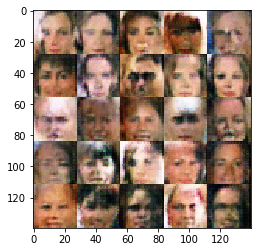

Epoch 0/1  Discriminator Loss: 1.4303   Generator Loss: 0.7536  
Epoch 0/1  Discriminator Loss: 1.3122   Generator Loss: 0.8128  
Epoch 0/1  Discriminator Loss: 1.4112   Generator Loss: 0.7684  
Epoch 0/1  Discriminator Loss: 1.3947   Generator Loss: 0.8045  
Epoch 0/1  Discriminator Loss: 1.3877   Generator Loss: 0.7926  
Epoch 0/1  Discriminator Loss: 1.3511   Generator Loss: 0.8167  
Epoch 0/1  Discriminator Loss: 1.3692   Generator Loss: 0.8214  
Epoch 0/1  Discriminator Loss: 1.4001   Generator Loss: 0.8034  
Epoch 0/1  Discriminator Loss: 1.3817   Generator Loss: 0.7777  
Epoch 0/1  Discriminator Loss: 1.4282   Generator Loss: 0.7273  


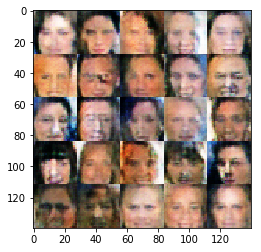

Epoch 0/1  Discriminator Loss: 1.3711   Generator Loss: 0.7557  
Epoch 0/1  Discriminator Loss: 1.3576   Generator Loss: 0.8101  
Epoch 0/1  Discriminator Loss: 1.3887   Generator Loss: 0.7809  
Epoch 0/1  Discriminator Loss: 1.3659   Generator Loss: 0.8021  
Epoch 0/1  Discriminator Loss: 1.3964   Generator Loss: 0.7811  
Epoch 0/1  Discriminator Loss: 1.3784   Generator Loss: 0.7686  
Epoch 0/1  Discriminator Loss: 1.3550   Generator Loss: 0.7983  
Epoch 0/1  Discriminator Loss: 1.3882   Generator Loss: 0.7879  
Epoch 0/1  Discriminator Loss: 1.3712   Generator Loss: 0.7684  
Epoch 0/1  Discriminator Loss: 1.3953   Generator Loss: 0.7863  


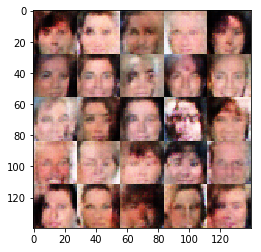

Epoch 0/1  Discriminator Loss: 1.3687   Generator Loss: 0.7996  
Epoch 0/1  Discriminator Loss: 1.3885   Generator Loss: 0.7772  
Epoch 0/1  Discriminator Loss: 1.4012   Generator Loss: 0.7920  
Epoch 0/1  Discriminator Loss: 1.4269   Generator Loss: 0.7614  
Epoch 0/1  Discriminator Loss: 1.3498   Generator Loss: 0.7993  
Epoch 0/1  Discriminator Loss: 1.3845   Generator Loss: 0.8033  
Epoch 0/1  Discriminator Loss: 1.4187   Generator Loss: 0.7295  
Epoch 0/1  Discriminator Loss: 1.4196   Generator Loss: 0.7656  
Epoch 0/1  Discriminator Loss: 1.3245   Generator Loss: 0.8057  
Epoch 0/1  Discriminator Loss: 1.4311   Generator Loss: 0.7462  


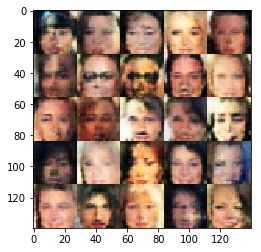

Epoch 0/1  Discriminator Loss: 1.3755   Generator Loss: 0.7836  
Epoch 0/1  Discriminator Loss: 1.3408   Generator Loss: 0.8055  
Epoch 0/1  Discriminator Loss: 1.3675   Generator Loss: 0.7925  
Epoch 0/1  Discriminator Loss: 1.4156   Generator Loss: 0.7373  
Epoch 0/1  Discriminator Loss: 1.4070   Generator Loss: 0.7666  
Epoch 0/1  Discriminator Loss: 1.4363   Generator Loss: 0.7944  
Epoch 0/1  Discriminator Loss: 1.3686   Generator Loss: 0.8174  
Epoch 0/1  Discriminator Loss: 1.4216   Generator Loss: 0.7563  
Epoch 0/1  Discriminator Loss: 1.3707   Generator Loss: 0.8238  
Epoch 0/1  Discriminator Loss: 1.3783   Generator Loss: 0.7977  


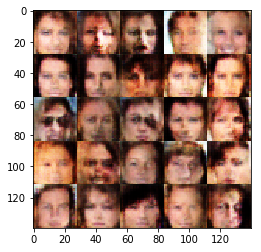

Epoch 0/1  Discriminator Loss: 1.4057   Generator Loss: 0.7479  
Epoch 0/1  Discriminator Loss: 1.3479   Generator Loss: 0.7975  
Epoch 0/1  Discriminator Loss: 1.3859   Generator Loss: 0.8020  
Epoch 0/1  Discriminator Loss: 1.4437   Generator Loss: 0.7752  
Epoch 0/1  Discriminator Loss: 1.3899   Generator Loss: 0.7667  
Epoch 0/1  Discriminator Loss: 1.4488   Generator Loss: 0.7609  
Epoch 0/1  Discriminator Loss: 1.3849   Generator Loss: 0.7800  
Epoch 0/1  Discriminator Loss: 1.3164   Generator Loss: 0.8145  
Epoch 0/1  Discriminator Loss: 1.4245   Generator Loss: 0.7241  
Epoch 0/1  Discriminator Loss: 1.3071   Generator Loss: 0.8069  


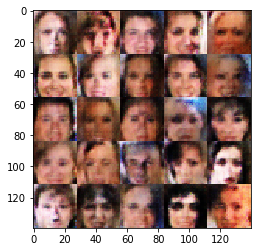

Epoch 0/1  Discriminator Loss: 1.3933   Generator Loss: 0.8051  
Epoch 0/1  Discriminator Loss: 1.3767   Generator Loss: 0.7331  
Epoch 0/1  Discriminator Loss: 1.3334   Generator Loss: 0.8209  
Epoch 0/1  Discriminator Loss: 1.4271   Generator Loss: 0.7886  
Epoch 0/1  Discriminator Loss: 1.3933   Generator Loss: 0.7790  
Epoch 0/1  Discriminator Loss: 1.3882   Generator Loss: 0.8057  
Epoch 0/1  Discriminator Loss: 1.3726   Generator Loss: 0.7676  
Epoch 0/1  Discriminator Loss: 1.4058   Generator Loss: 0.7745  
Epoch 0/1  Discriminator Loss: 1.3403   Generator Loss: 0.7974  
Epoch 0/1  Discriminator Loss: 1.3998   Generator Loss: 0.7269  


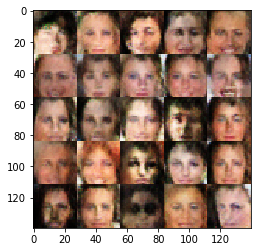

Epoch 0/1  Discriminator Loss: 1.3243   Generator Loss: 0.7899  
Epoch 0/1  Discriminator Loss: 1.3980   Generator Loss: 0.7397  
Epoch 0/1  Discriminator Loss: 1.3776   Generator Loss: 0.7577  
Epoch 0/1  Discriminator Loss: 1.3390   Generator Loss: 0.8240  
Epoch 0/1  Discriminator Loss: 1.3955   Generator Loss: 0.7477  
Epoch 0/1  Discriminator Loss: 1.3501   Generator Loss: 0.8313  
Epoch 0/1  Discriminator Loss: 1.4246   Generator Loss: 0.7983  
Epoch 0/1  Discriminator Loss: 1.3782   Generator Loss: 0.7338  
Epoch 0/1  Discriminator Loss: 1.3682   Generator Loss: 0.7798  
Epoch 0/1  Discriminator Loss: 1.4280   Generator Loss: 0.7446  


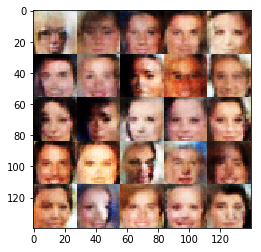

Epoch 0/1  Discriminator Loss: 1.3169   Generator Loss: 0.8083  
Epoch 0/1  Discriminator Loss: 1.3670   Generator Loss: 0.7583  
Epoch 0/1  Discriminator Loss: 1.4580   Generator Loss: 0.7260  
Epoch 0/1  Discriminator Loss: 1.3232   Generator Loss: 0.8030  
Epoch 0/1  Discriminator Loss: 1.4334   Generator Loss: 0.7572  
Epoch 0/1  Discriminator Loss: 1.3536   Generator Loss: 0.8248  
Epoch 0/1  Discriminator Loss: 1.3578   Generator Loss: 0.7986  
Epoch 0/1  Discriminator Loss: 1.3739   Generator Loss: 0.7551  
Epoch 0/1  Discriminator Loss: 1.4156   Generator Loss: 0.7627  
Epoch 0/1  Discriminator Loss: 1.3308   Generator Loss: 0.8577  


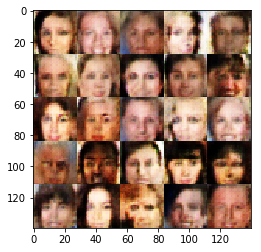

Epoch 0/1  Discriminator Loss: 1.3978   Generator Loss: 0.7391  
Epoch 0/1  Discriminator Loss: 1.4206   Generator Loss: 0.7643  
Epoch 0/1  Discriminator Loss: 1.3437   Generator Loss: 0.8313  
Epoch 0/1  Discriminator Loss: 1.4409   Generator Loss: 0.7415  
Epoch 0/1  Discriminator Loss: 1.3699   Generator Loss: 0.8124  
Epoch 0/1  Discriminator Loss: 1.3339   Generator Loss: 0.8293  
Epoch 0/1  Discriminator Loss: 1.4058   Generator Loss: 0.7399  
Epoch 0/1  Discriminator Loss: 1.4281   Generator Loss: 0.7539  
Epoch 0/1  Discriminator Loss: 1.3665   Generator Loss: 0.7703  
Epoch 0/1  Discriminator Loss: 1.3733   Generator Loss: 0.7996  


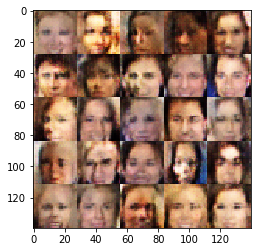

Epoch 0/1  Discriminator Loss: 1.3808   Generator Loss: 0.7488  
Epoch 0/1  Discriminator Loss: 1.3752   Generator Loss: 0.7814  
Epoch 0/1  Discriminator Loss: 1.3886   Generator Loss: 0.7557  
Epoch 0/1  Discriminator Loss: 1.3738   Generator Loss: 0.8251  
Epoch 0/1  Discriminator Loss: 1.4244   Generator Loss: 0.7835  
Epoch 0/1  Discriminator Loss: 1.3900   Generator Loss: 0.7469  
Epoch 0/1  Discriminator Loss: 1.4033   Generator Loss: 0.7853  
Epoch 0/1  Discriminator Loss: 1.4136   Generator Loss: 0.8052  
Epoch 0/1  Discriminator Loss: 1.3396   Generator Loss: 0.8023  
Epoch 0/1  Discriminator Loss: 1.4340   Generator Loss: 0.7677  


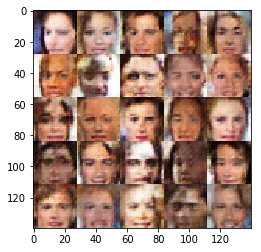

Epoch 0/1  Discriminator Loss: 1.3984   Generator Loss: 0.7899  
Epoch 0/1  Discriminator Loss: 1.3469   Generator Loss: 0.8150  
Epoch 0/1  Discriminator Loss: 1.3923   Generator Loss: 0.7533  
Epoch 0/1  Discriminator Loss: 1.3847   Generator Loss: 0.8057  
Epoch 0/1  Discriminator Loss: 1.4537   Generator Loss: 0.7385  
Epoch 0/1  Discriminator Loss: 1.3933   Generator Loss: 0.7691  
Epoch 0/1  Discriminator Loss: 1.3943   Generator Loss: 0.8121  
Epoch 0/1  Discriminator Loss: 1.3798   Generator Loss: 0.7868  
Epoch 0/1  Discriminator Loss: 1.3989   Generator Loss: 0.7728  
Epoch 0/1  Discriminator Loss: 1.4050   Generator Loss: 0.7889  


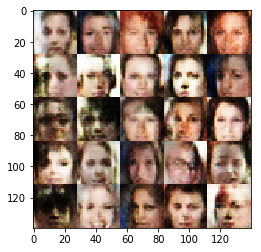

Epoch 0/1  Discriminator Loss: 1.4132   Generator Loss: 0.7755  
Epoch 0/1  Discriminator Loss: 1.3280   Generator Loss: 0.8199  
Epoch 0/1  Discriminator Loss: 1.4025   Generator Loss: 0.7693  
Epoch 0/1  Discriminator Loss: 1.3821   Generator Loss: 0.7625  
Epoch 0/1  Discriminator Loss: 1.3598   Generator Loss: 0.7976  
Epoch 0/1  Discriminator Loss: 1.3568   Generator Loss: 0.7805  
Epoch 0/1  Discriminator Loss: 1.3509   Generator Loss: 0.7893  
Epoch 0/1  Discriminator Loss: 1.4099   Generator Loss: 0.7257  
Epoch 0/1  Discriminator Loss: 1.3765   Generator Loss: 0.8362  
Epoch 0/1  Discriminator Loss: 1.4111   Generator Loss: 0.8152  


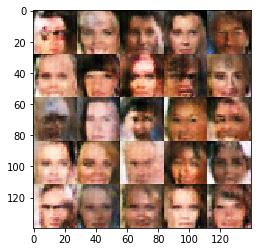

Epoch 0/1  Discriminator Loss: 1.3768   Generator Loss: 0.7824  
Epoch 0/1  Discriminator Loss: 1.3714   Generator Loss: 0.8040  
Epoch 0/1  Discriminator Loss: 1.3930   Generator Loss: 0.7776  
Epoch 0/1  Discriminator Loss: 1.3934   Generator Loss: 0.7994  
Epoch 0/1  Discriminator Loss: 1.3845   Generator Loss: 0.7888  
Epoch 0/1  Discriminator Loss: 1.3931   Generator Loss: 0.7838  
Epoch 0/1  Discriminator Loss: 1.4205   Generator Loss: 0.8089  
Epoch 0/1  Discriminator Loss: 1.3827   Generator Loss: 0.7794  
Epoch 0/1  Discriminator Loss: 1.3899   Generator Loss: 0.7774  
Epoch 0/1  Discriminator Loss: 1.3870   Generator Loss: 0.7859  


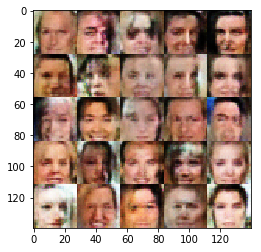

Epoch 0/1  Discriminator Loss: 1.4354   Generator Loss: 0.7531  
Epoch 0/1  Discriminator Loss: 1.4291   Generator Loss: 0.7245  
Epoch 0/1  Discriminator Loss: 1.4136   Generator Loss: 0.8051  
Epoch 0/1  Discriminator Loss: 1.3966   Generator Loss: 0.7859  
Epoch 0/1  Discriminator Loss: 1.3919   Generator Loss: 0.7954  
Epoch 0/1  Discriminator Loss: 1.4144   Generator Loss: 0.7525  
Epoch 0/1  Discriminator Loss: 1.4203   Generator Loss: 0.7542  
Epoch 0/1  Discriminator Loss: 1.4093   Generator Loss: 0.7723  
Epoch 0/1  Discriminator Loss: 1.4158   Generator Loss: 0.7496  
Epoch 0/1  Discriminator Loss: 1.4211   Generator Loss: 0.7638  


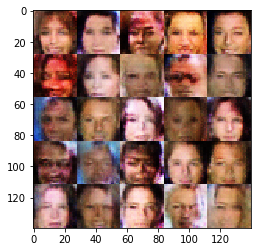

Epoch 0/1  Discriminator Loss: 1.4090   Generator Loss: 0.8001  
Epoch 0/1  Discriminator Loss: 1.3900   Generator Loss: 0.7667  
Epoch 0/1  Discriminator Loss: 1.3912   Generator Loss: 0.7946  
Epoch 0/1  Discriminator Loss: 1.3876   Generator Loss: 0.7385  
Epoch 0/1  Discriminator Loss: 1.3363   Generator Loss: 0.8048  
Epoch 0/1  Discriminator Loss: 1.3616   Generator Loss: 0.8031  
Epoch 0/1  Discriminator Loss: 1.3782   Generator Loss: 0.8153  
Epoch 0/1  Discriminator Loss: 1.3905   Generator Loss: 0.7739  
Epoch 0/1  Discriminator Loss: 1.3866   Generator Loss: 0.7958  
Epoch 0/1  Discriminator Loss: 1.3947   Generator Loss: 0.7704  


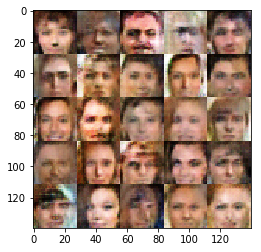

Epoch 0/1  Discriminator Loss: 1.4034   Generator Loss: 0.7536  
Epoch 0/1  Discriminator Loss: 1.4388   Generator Loss: 0.7275  
Epoch 0/1  Discriminator Loss: 1.3728   Generator Loss: 0.8009  
Epoch 0/1  Discriminator Loss: 1.3790   Generator Loss: 0.8088  
Epoch 0/1  Discriminator Loss: 1.3720   Generator Loss: 0.7773  
Epoch 0/1  Discriminator Loss: 1.3399   Generator Loss: 0.7869  
Epoch 0/1  Discriminator Loss: 1.3828   Generator Loss: 0.7922  
Epoch 0/1  Discriminator Loss: 1.4062   Generator Loss: 0.7484  
Epoch 0/1  Discriminator Loss: 1.4036   Generator Loss: 0.7653  
Epoch 0/1  Discriminator Loss: 1.3903   Generator Loss: 0.8035  


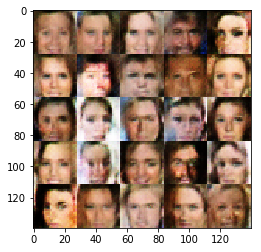

Epoch 0/1  Discriminator Loss: 1.4241   Generator Loss: 0.7361  
Epoch 0/1  Discriminator Loss: 1.4039   Generator Loss: 0.7371  
Epoch 0/1  Discriminator Loss: 1.3772   Generator Loss: 0.7752  
Epoch 0/1  Discriminator Loss: 1.3626   Generator Loss: 0.8119  
Epoch 0/1  Discriminator Loss: 1.4126   Generator Loss: 0.7604  
Epoch 0/1  Discriminator Loss: 1.3728   Generator Loss: 0.8052  
Epoch 0/1  Discriminator Loss: 1.3593   Generator Loss: 0.8144  
Epoch 0/1  Discriminator Loss: 1.3733   Generator Loss: 0.7826  
Epoch 0/1  Discriminator Loss: 1.3894   Generator Loss: 0.8076  
Epoch 0/1  Discriminator Loss: 1.3710   Generator Loss: 0.7763  


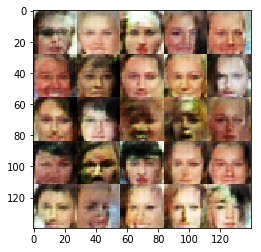

Epoch 0/1  Discriminator Loss: 1.3448   Generator Loss: 0.7974  
Epoch 0/1  Discriminator Loss: 1.4092   Generator Loss: 0.7633  
Epoch 0/1  Discriminator Loss: 1.3810   Generator Loss: 0.7792  
Epoch 0/1  Discriminator Loss: 1.3743   Generator Loss: 0.8166  
Epoch 0/1  Discriminator Loss: 1.4438   Generator Loss: 0.7274  
Epoch 0/1  Discriminator Loss: 1.3497   Generator Loss: 0.8251  
Epoch 0/1  Discriminator Loss: 1.3928   Generator Loss: 0.7820  
Epoch 0/1  Discriminator Loss: 1.4531   Generator Loss: 0.7353  
Epoch 0/1  Discriminator Loss: 1.3840   Generator Loss: 0.7919  
Epoch 0/1  Discriminator Loss: 1.4144   Generator Loss: 0.7476  


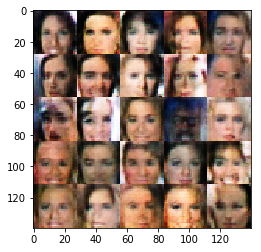

Epoch 0/1  Discriminator Loss: 1.3710   Generator Loss: 0.8165  
Epoch 0/1  Discriminator Loss: 1.3876   Generator Loss: 0.7992  
Epoch 0/1  Discriminator Loss: 1.3896   Generator Loss: 0.7714  
Epoch 0/1  Discriminator Loss: 1.4075   Generator Loss: 0.7451  
Epoch 0/1  Discriminator Loss: 1.3782   Generator Loss: 0.7858  
Epoch 0/1  Discriminator Loss: 1.3419   Generator Loss: 0.8330  
Epoch 0/1  Discriminator Loss: 1.3923   Generator Loss: 0.7827  
Epoch 0/1  Discriminator Loss: 1.3897   Generator Loss: 0.7636  
Epoch 0/1  Discriminator Loss: 1.4163   Generator Loss: 0.7762  
Epoch 0/1  Discriminator Loss: 1.3095   Generator Loss: 0.8491  


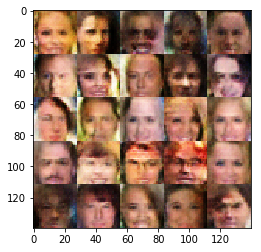

Epoch 0/1  Discriminator Loss: 1.3908   Generator Loss: 0.7639  
Epoch 0/1  Discriminator Loss: 1.4116   Generator Loss: 0.7547  
Epoch 0/1  Discriminator Loss: 1.4212   Generator Loss: 0.7632  
Epoch 0/1  Discriminator Loss: 1.3946   Generator Loss: 0.7453  
Epoch 0/1  Discriminator Loss: 1.3850   Generator Loss: 0.7856  
Epoch 0/1  Discriminator Loss: 1.3635   Generator Loss: 0.7814  
Epoch 0/1  Discriminator Loss: 1.3607   Generator Loss: 0.7804  
Epoch 0/1  Discriminator Loss: 1.4289   Generator Loss: 0.7641  
Epoch 0/1  Discriminator Loss: 1.3780   Generator Loss: 0.8203  
Epoch 0/1  Discriminator Loss: 1.4158   Generator Loss: 0.7674  


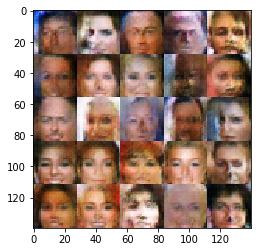

Epoch 0/1  Discriminator Loss: 1.3844   Generator Loss: 0.7673  
Epoch 0/1  Discriminator Loss: 1.3447   Generator Loss: 0.8350  
Epoch 0/1  Discriminator Loss: 1.4155   Generator Loss: 0.7969  
Epoch 0/1  Discriminator Loss: 1.3816   Generator Loss: 0.7906  
Epoch 0/1  Discriminator Loss: 1.3359   Generator Loss: 0.8207  
Epoch 0/1  Discriminator Loss: 1.4283   Generator Loss: 0.7947  
Epoch 0/1  Discriminator Loss: 1.3978   Generator Loss: 0.7924  
Epoch 0/1  Discriminator Loss: 1.3737   Generator Loss: 0.7994  
Epoch 0/1  Discriminator Loss: 1.3792   Generator Loss: 0.7906  
Epoch 0/1  Discriminator Loss: 1.3935   Generator Loss: 0.8036  


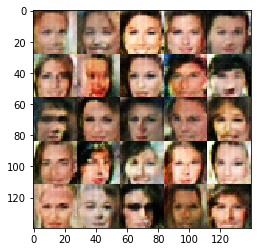

Epoch 0/1  Discriminator Loss: 1.3175   Generator Loss: 0.8412  
Epoch 0/1  Discriminator Loss: 1.3985   Generator Loss: 0.7593  
Epoch 0/1  Discriminator Loss: 1.3966   Generator Loss: 0.7914  
Epoch 0/1  Discriminator Loss: 1.4350   Generator Loss: 0.7515  
Epoch 0/1  Discriminator Loss: 1.3893   Generator Loss: 0.7884  
Epoch 0/1  Discriminator Loss: 1.3459   Generator Loss: 0.8015  
Epoch 0/1  Discriminator Loss: 1.4281   Generator Loss: 0.7521  
Epoch 0/1  Discriminator Loss: 1.3924   Generator Loss: 0.7483  
Epoch 0/1  Discriminator Loss: 1.4142   Generator Loss: 0.8037  
Epoch 0/1  Discriminator Loss: 1.3503   Generator Loss: 0.7952  


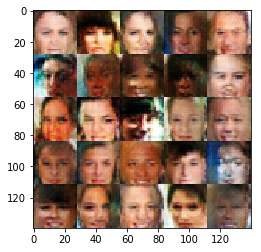

Epoch 0/1  Discriminator Loss: 1.4422   Generator Loss: 0.7310  
Epoch 0/1  Discriminator Loss: 1.3712   Generator Loss: 0.8157  
Epoch 0/1  Discriminator Loss: 1.4004   Generator Loss: 0.8152  
Epoch 0/1  Discriminator Loss: 1.4243   Generator Loss: 0.7642  
Epoch 0/1  Discriminator Loss: 1.4169   Generator Loss: 0.7693  
Epoch 0/1  Discriminator Loss: 1.3741   Generator Loss: 0.7689  
Epoch 0/1  Discriminator Loss: 1.3918   Generator Loss: 0.8112  
Epoch 0/1  Discriminator Loss: 1.3864   Generator Loss: 0.7747  
Epoch 0/1  Discriminator Loss: 1.3802   Generator Loss: 0.8125  
Epoch 0/1  Discriminator Loss: 1.3885   Generator Loss: 0.8042  


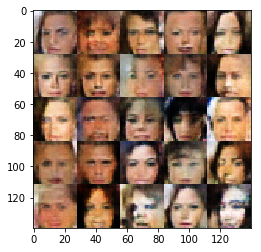

Epoch 0/1  Discriminator Loss: 1.3581   Generator Loss: 0.8062  
Epoch 0/1  Discriminator Loss: 1.3756   Generator Loss: 0.7986  
Epoch 0/1  Discriminator Loss: 1.3882   Generator Loss: 0.7367  
Epoch 0/1  Discriminator Loss: 1.4085   Generator Loss: 0.7793  
Epoch 0/1  Discriminator Loss: 1.3619   Generator Loss: 0.8144  
Epoch 0/1  Discriminator Loss: 1.3970   Generator Loss: 0.7649  
Epoch 0/1  Discriminator Loss: 1.3690   Generator Loss: 0.8117  
Epoch 0/1  Discriminator Loss: 1.4431   Generator Loss: 0.7180  
Epoch 0/1  Discriminator Loss: 1.3965   Generator Loss: 0.7696  
Epoch 0/1  Discriminator Loss: 1.3972   Generator Loss: 0.7704  


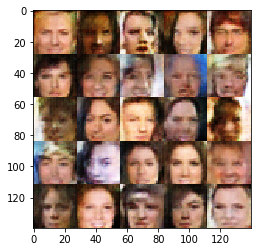

Epoch 0/1  Discriminator Loss: 1.3849   Generator Loss: 0.7654  
Epoch 0/1  Discriminator Loss: 1.4269   Generator Loss: 0.7652  
Epoch 0/1  Discriminator Loss: 1.3444   Generator Loss: 0.8132  
Epoch 0/1  Discriminator Loss: 1.3843   Generator Loss: 0.7939  
Epoch 0/1  Discriminator Loss: 1.3688   Generator Loss: 0.7986  
Epoch 0/1  Discriminator Loss: 1.4041   Generator Loss: 0.8114  
Epoch 0/1  Discriminator Loss: 1.4401   Generator Loss: 0.7393  
Epoch 0/1  Discriminator Loss: 1.3903   Generator Loss: 0.7791  
Epoch 0/1  Discriminator Loss: 1.3602   Generator Loss: 0.8152  
Epoch 0/1  Discriminator Loss: 1.3663   Generator Loss: 0.8076  


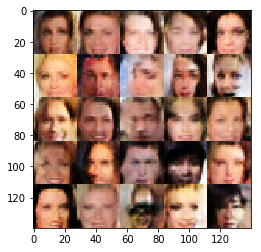

Epoch 0/1  Discriminator Loss: 1.3838   Generator Loss: 0.7471  
Epoch 0/1  Discriminator Loss: 1.4008   Generator Loss: 0.7763  
Epoch 0/1  Discriminator Loss: 1.3803   Generator Loss: 0.7919  
Epoch 0/1  Discriminator Loss: 1.3285   Generator Loss: 0.8110  
Epoch 0/1  Discriminator Loss: 1.4471   Generator Loss: 0.7072  
Epoch 0/1  Discriminator Loss: 1.4061   Generator Loss: 0.7623  
Epoch 0/1  Discriminator Loss: 1.4167   Generator Loss: 0.7415  
Epoch 0/1  Discriminator Loss: 1.3810   Generator Loss: 0.7752  
Epoch 0/1  Discriminator Loss: 1.3663   Generator Loss: 0.8092  
Epoch 0/1  Discriminator Loss: 1.3909   Generator Loss: 0.8046  


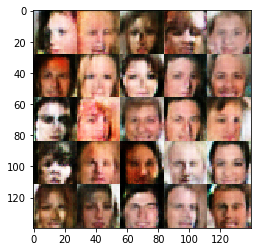

Epoch 0/1  Discriminator Loss: 1.3808   Generator Loss: 0.7750  
Epoch 0/1  Discriminator Loss: 1.3806   Generator Loss: 0.7719  
Epoch 0/1  Discriminator Loss: 1.3691   Generator Loss: 0.7885  
Epoch 0/1  Discriminator Loss: 1.4397   Generator Loss: 0.7531  
Epoch 0/1  Discriminator Loss: 1.4421   Generator Loss: 0.7870  
Epoch 0/1  Discriminator Loss: 1.4108   Generator Loss: 0.7795  
Epoch 0/1  Discriminator Loss: 1.3853   Generator Loss: 0.7821  
Epoch 0/1  Discriminator Loss: 1.3909   Generator Loss: 0.7745  
Epoch 0/1  Discriminator Loss: 1.3492   Generator Loss: 0.7963  
Epoch 0/1  Discriminator Loss: 1.3565   Generator Loss: 0.8016  


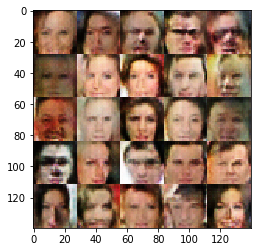

Epoch 0/1  Discriminator Loss: 1.4042   Generator Loss: 0.8123  
Epoch 0/1  Discriminator Loss: 1.3892   Generator Loss: 0.7517  
Epoch 0/1  Discriminator Loss: 1.3954   Generator Loss: 0.7889  
Epoch 0/1  Discriminator Loss: 1.3334   Generator Loss: 0.8034  
Epoch 0/1  Discriminator Loss: 1.4186   Generator Loss: 0.7504  
Epoch 0/1  Discriminator Loss: 1.3928   Generator Loss: 0.7715  
Epoch 0/1  Discriminator Loss: 1.3856   Generator Loss: 0.7833  
Epoch 0/1  Discriminator Loss: 1.3978   Generator Loss: 0.7777  
Epoch 0/1  Discriminator Loss: 1.3863   Generator Loss: 0.7796  
Epoch 0/1  Discriminator Loss: 1.4119   Generator Loss: 0.7790  


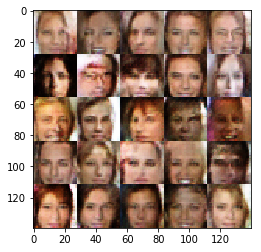

Epoch 0/1  Discriminator Loss: 1.3830   Generator Loss: 0.7750  
Epoch 0/1  Discriminator Loss: 1.4172   Generator Loss: 0.7602  
Epoch 0/1  Discriminator Loss: 1.3369   Generator Loss: 0.7959  
Epoch 0/1  Discriminator Loss: 1.3462   Generator Loss: 0.7893  
Epoch 0/1  Discriminator Loss: 1.4031   Generator Loss: 0.7602  
Epoch 0/1  Discriminator Loss: 1.4152   Generator Loss: 0.7693  
Epoch 0/1  Discriminator Loss: 1.4072   Generator Loss: 0.8048  
Epoch 0/1  Discriminator Loss: 1.4063   Generator Loss: 0.7699  
Epoch 0/1  Discriminator Loss: 1.4307   Generator Loss: 0.7788  
Epoch 0/1  Discriminator Loss: 1.3840   Generator Loss: 0.7726  


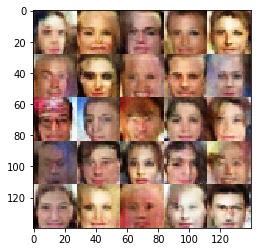

Epoch 0/1  Discriminator Loss: 1.3814   Generator Loss: 0.7774  
Epoch 0/1  Discriminator Loss: 1.3824   Generator Loss: 0.7724  
Epoch 0/1  Discriminator Loss: 1.3746   Generator Loss: 0.7509  
Epoch 0/1  Discriminator Loss: 1.4221   Generator Loss: 0.7543  
Epoch 0/1  Discriminator Loss: 1.3874   Generator Loss: 0.7714  
Epoch 0/1  Discriminator Loss: 1.4233   Generator Loss: 0.7586  
Epoch 0/1  Discriminator Loss: 1.3789   Generator Loss: 0.7949  
Epoch 0/1  Discriminator Loss: 1.3702   Generator Loss: 0.7923  
Epoch 0/1  Discriminator Loss: 1.4146   Generator Loss: 0.7643  
Epoch 0/1  Discriminator Loss: 1.4047   Generator Loss: 0.7648  


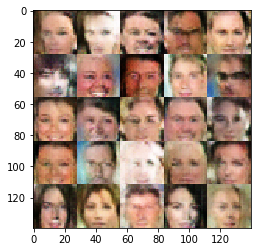

Epoch 0/1  Discriminator Loss: 1.3505   Generator Loss: 0.8150  
Epoch 0/1  Discriminator Loss: 1.4051   Generator Loss: 0.7706  
Epoch 0/1  Discriminator Loss: 1.3777   Generator Loss: 0.7781  
Epoch 0/1  Discriminator Loss: 1.4107   Generator Loss: 0.7463  
Epoch 0/1  Discriminator Loss: 1.3779   Generator Loss: 0.7890  
Epoch 0/1  Discriminator Loss: 1.3727   Generator Loss: 0.8105  
Epoch 0/1  Discriminator Loss: 1.4468   Generator Loss: 0.7834  
Epoch 0/1  Discriminator Loss: 1.3892   Generator Loss: 0.7915  
Epoch 0/1  Discriminator Loss: 1.4632   Generator Loss: 0.7094  
Epoch 0/1  Discriminator Loss: 1.3685   Generator Loss: 0.7942  


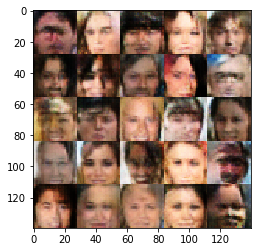

Epoch 0/1  Discriminator Loss: 1.4412   Generator Loss: 0.7642  
Epoch 0/1  Discriminator Loss: 1.4187   Generator Loss: 0.7340  
Epoch 0/1  Discriminator Loss: 1.3786   Generator Loss: 0.7812  


In [27]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.